# How can frog grow its tail back?


In [1]:
!pip install anndata
!pip install 'scanpy[leiden]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 5.8 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=32e2be5237d331e58e72ea3f7b958c2dc89e45c1b6f0c39aefed9b4059b7fffd
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In this starter we provide some built-in functions for PCA and subsequent Leiden Clustering. We do not reqruire you write down PCA in this task, but for more details as to how you should use it, `scanpy` uses the `sklearn` PCA routine - for `R` users, there might be some usage discrepancies. Scaling/centering data is not automatically done and can be a careful choice here. For additional information on single cell specific use, you can consult this [tutorial](https://training.galaxyproject.org/training-material/topics/single-cell/tutorials/scrna-scanpy-pbmc3k/tutorial.html#dimensionality-reduction).


For the project, ask yourself some questions: why do we do PCA? how does this affect our data? how does the scaling affect? should we scale? what is the impact of the processing steps? does the interpretation carry over from classical ML use? How does the two formulations of PCA help you understand what is going on here?

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Processing the data

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, fowlkes_mallows_score

In [4]:
import scanpy as sc
extract_dir = "/content/drive/MyDrive/"
adata = sc.read_h5ad(extract_dir+'cleaned_processed_frogtail.h5ad') # file path

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)

# Filter cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_genes=6000)
sc.pp.filter_cells(adata, max_counts=50000)

# Filter genes
sc.pp.filter_genes(adata, min_cells=3)

In [6]:
adata.X

<12985x26110 sparse matrix of type '<class 'numpy.int64'>'
	with 28418866 stored elements in Compressed Sparse Row format>

In [7]:
adata.obs.head()

barcode_cells                cell  sample DevelopmentalStage  \
0  AAACCTGAGCTAGTTC.1  AAACCTGAGCTAGTTC.1  SIGAB5               st40   
1  AAACCTGGTGGGTCAA.1  AAACCTGGTGGGTCAA.1  SIGAB5               st40   
2  AAACCTGGTTTGTTGG.1  AAACCTGGTTTGTTGG.1  SIGAB5               st40   
3  AAACGGGGTCGGCATC.1  AAACGGGGTCGGCATC.1  SIGAB5               st40   
4  AAACGGGTCCTACAGA.1  AAACGGGTCCTACAGA.1  SIGAB5               st40   

   DaysPostAmputation        cluster         X          Y CellCyclePhase  \
0                   3  Erythrocyte 4 -6.395430   0.832323            G2M   
1                   3      Myeloid 1 -2.428271  13.826715             G1   
2                   3  Beta ionocyte -1.398049 -14.653897             G1   
3                   3  Erythrocyte 4 -5.863765   0.489598            G2M   
4                   3    Goblet cell  2.106444  -6.594430             G1   

   Sample  ... n_genes_by_counts log1p_n_genes_by_counts  total_counts  \
0  SIGAB5  ...              2135                7.666690         21810   
1  SIGAB5  ...              2663                7.887584          9029   
2  SIGAB5  ...              1689                7.432484          5015   
3  SIGAB5  ...               956                6.863803          8182   
4  SIGAB5  ...              1438                7.271704          4205   

   log1p_total_counts  pct_counts_in_top_50_genes  \
0            9.990170                   66.662082   
1            9.108308                   26.813601   
2            8.520388                   31.844467   
3            9.009814                   72.671718   
4            8.344267                   27.586207   

   pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
0                    75.089409                    83.718478   
1                    38.188061                    52.287075   
2                    42.452642                    55.294118   
3                    81.019311                    88.548032   
4                    41.997622                    58.454221   

   pct_counts_in_top_500_genes  n_genes  n_counts  
0                    90.632737     2135     21810  
1                    68.855909     2663      9029  
2                    73.479561     1689      5015  
3                    94.426791      956      8182  
4                    77.455410     1438      4205  

[5 rows x 23 columns]

In [8]:
adata.var

n_cells_by_counts  mean_counts  log1p_mean_counts  \
Xelaev18000003m.g                199     0.022653           0.022400   
Xelaev18000005m.g                  3     0.000227           0.000227   
tm6sf2.1                         316     0.026972           0.026614   
Xelaev18000007m.g                 16     0.001667           0.001665   
bpi.S                           1293     0.157739           0.146469   
...                              ...          ...                ...   
loc100492292.S                  1075     0.089931           0.086114   
rnf112.S                         318     0.035381           0.034770   
loc101731436.S                   368     0.029017           0.028604   
loc398467.S                     2138     0.286764           0.252131   
Xetrov90026938m.S                281     0.023562           0.023289   

                   pct_dropout_by_counts  total_counts  log1p_total_counts  \
Xelaev18000003m.g              98.492310           299            5.703782   
Xelaev18000005m.g              99.977271             3            1.386294   
tm6sf2.1                       97.605879           356            5.877736   
Xelaev18000007m.g              99.878779            22            3.135494   
bpi.S                          90.203803          2082            7.641564   
...                                  ...           ...                 ...   
loc100492292.S                 91.855444          1187            7.080026   
rnf112.S                       97.590727           467            6.148468   
loc101731436.S                 97.211910           383            5.950643   
loc398467.S                    83.801803          3785            8.239065   
Xetrov90026938m.S              97.871051           311            5.743003   

                   n_cells  
Xelaev18000003m.g      191  
Xelaev18000005m.g        3  
tm6sf2.1               307  
Xelaev18000007m.g       15  
bpi.S                 1274  
...                    ...  
loc100492292.S        1029  
rnf112.S               305  
loc101731436.S         362  
loc398467.S           2079  
Xetrov90026938m.S      279  

[26110 rows x 7 columns]

In [9]:
adata.X

<12985x26110 sparse matrix of type '<class 'numpy.int64'>'
	with 28418866 stored elements in Compressed Sparse Row format>

In [10]:
adata.X.toarray()[:5, :20]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [11]:
print(adata.X)

  (0, 13)	2
  (0, 23)	1
  (0, 45)	124
  (0, 64)	1
  (0, 78)	1
  (0, 89)	9
  (0, 99)	1
  (0, 128)	2
  (0, 129)	1
  (0, 160)	1
  (0, 169)	1
  (0, 173)	5
  (0, 184)	1
  (0, 186)	1
  (0, 195)	1
  (0, 204)	1
  (0, 250)	1
  (0, 265)	1
  (0, 268)	1
  (0, 272)	1
  (0, 281)	4
  (0, 283)	1
  (0, 296)	3
  (0, 302)	2
  (0, 330)	3
  :	:
  (12984, 25469)	1
  (12984, 25525)	1
  (12984, 25587)	1
  (12984, 25602)	1
  (12984, 25610)	2
  (12984, 25612)	1
  (12984, 25673)	2
  (12984, 25690)	1
  (12984, 25695)	12
  (12984, 25794)	4
  (12984, 25799)	1
  (12984, 25803)	5
  (12984, 25810)	1
  (12984, 25818)	18
  (12984, 25822)	3
  (12984, 25828)	4
  (12984, 25862)	10
  (12984, 25882)	1
  (12984, 25892)	2
  (12984, 25921)	1
  (12984, 25979)	1
  (12984, 25983)	1
  (12984, 26023)	1
  (12984, 26050)	2
  (12984, 26065)	1


We need to select a timepoint. Let's plot them out first.

<Axes: xlabel='DaysPostAmputation', ylabel='Count'>

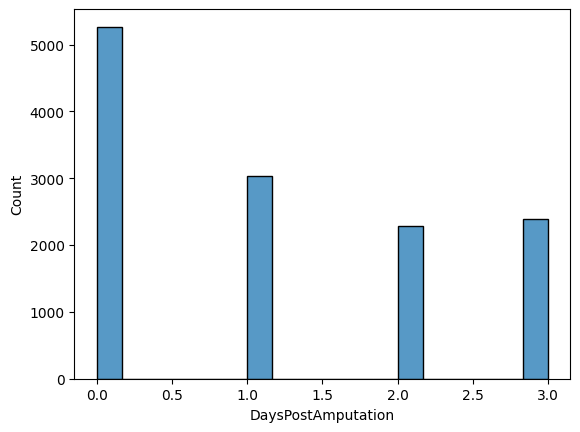

In [12]:
import seaborn as sns
sns.histplot(adata.obs['DaysPostAmputation'])

Selecting timepoint 0 (Day of amputation).

In [13]:
adata = adata[adata.obs['DaysPostAmputation'] == 0] # Subset on the time point 0
adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer

<ipython-input-13-88f00e64bca0>:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer


HW1B: Exercise 3. Preprocessing for your project 1
Explore your data and the effect of data processing on clustering. You can find the data for
the project, the original paper and resources here.
1. Pick one time point/condition
2. Use provided code to do quality control and normalization: do you normalize per column or per row?

(a) Pick the top 10 most variable genes

(b) Pick the top 10 genes with highest mean

(c) Pick the top 10 most informative genes

(d) Pick 10 random genes

In [14]:
import numpy as np
import pandas as pd
import random

# Copy the adata object
subset_data = adata.copy()

# Convert the sparse matrix to a dense matrix for processing
X_dense = subset_data.X.toarray() if not isinstance(subset_data.X, np.ndarray) else subset_data.X

# Ensure the matrix is of floating-point type
X_dense = X_dense.astype(np.float32)

# Assign the converted matrix back to the AnnData object
subset_data.X = X_dense

# Calculate the variance of each gene across all cells
gene_variances = np.var(X_dense, axis=0)

# Create a DataFrame for the genes and their variances
gene_variance_df = pd.DataFrame({
    'gene': subset_data.var_names,
    'variance': gene_variances
})

# Sort the genes by variance and pick the top 2000
top_2000_genes = gene_variance_df.sort_values(by='variance', ascending=False).head(2000)['gene'].tolist()

print("Top 2000 highly variable genes selected.")

# Add a 'highly_variable' column to indicate the top 2000 genes
subset_data.var['highly_variable'] = subset_data.var_names.isin(top_2000_genes)

# (a) Top 10 Most Variable Genes
top_variable_genes = gene_variance_df.sort_values(by='variance', ascending=False).head(10)['gene'].tolist()
print("Top 10 Most Variable Genes:", top_variable_genes)

# (b) Top 10 Genes with Highest Mean Expression
mean_expression = X_dense.mean(axis=0)  # Get the mean expression for each gene across cells (columns)
mean_expression_series = pd.Series(mean_expression, index=subset_data.var_names)
top_mean_genes = mean_expression_series.sort_values(ascending=False).index[:10].tolist()
print("Top 10 Genes with Highest Mean Expression:", top_mean_genes)

# (c) Top 10 Most Informative Genes
sc.tl.pca(subset_data, n_comps=50)
loadings = pd.DataFrame(subset_data.varm['PCs'], index=subset_data.var_names)
loadings['sum_abs_loading'] = loadings.abs().sum(axis=1)
top_informative_genes = loadings.sort_values('sum_abs_loading', ascending=False).index[:10].tolist()
print("Top 10 Most Informative Genes:", top_informative_genes)

# (d) 10 Random Genes
random_genes = random.sample(list(subset_data.var_names), 10)
print("10 Random Genes:", random_genes)


Top 2000 highly variable genes selected.
Top 10 Most Variable Genes: ['hbd.S', 'Xelaev18045099m.g', 'hbd.L', 'Xelaev18045098m.g', 'Xelaev18047464m.g', 'Xelaev18045083m.g', 'Xelaev18045096m.g', 'Xelaev18045084m.g', 'Xelaev18047460m.g', 'Xelaev18045082m.g']
Top 10 Genes with Highest Mean Expression: ['hbd.S', 'Xelaev18045099m.g', 'hbd.L', 'Xelaev18045098m.g', 'Xelaev18047464m.g', 'Xelaev18045083m.g', 'Xelaev18045096m.g', 'Xelaev18045084m.g', 'Xelaev18047455m.g', 'Xelaev18047460m.g']
Top 10 Most Informative Genes: ['tmsb4x.L', 'loc100494945.S', 'Xelaev18045084m.g', 'loc100494945.L', 'Xelaev18047464m.g', 'loc100127564.L', 'Xelaev18045096m.g', 'Xelaev18045082m.g', 'Xelaev18022166m.g', 'Xelaev18047452m.g']
10 Random Genes: ['Xelaev18003400m.g', 'dtwd1.L', 'Xelaev18031416m.g', 'loc100497622.like.L', 'loc100489640.L', 'sema3f.S', 'Xelaev18030752m.g', 'fam76b.L', 'Xelaev18021290m.g', 'c12orf57.L']


Top 10 Most Variable Genes: ['Xelaev18018852m.g', 'Xelaev18047607m.g', 'loc100496565.S', 'Xelaev18039168m.g', 'tnnc2.S', 'ctgfl.L', 'tyrp1.L', 'otog.S', 'tnni2.S', 'pmel.like.L']

Top 10 Genes with Highest Mean: ['ndufa6.L', 'hnrnph3.S', 'rad23b.S', 'ndufa1.S', 'psmb5.S', 'erh.S', 'nop58.L', 'ccdc25.L', 'mrps6.S', 'Xelaev18042878m.g']

Top 10 Most Informative Genes': ['ndufa6.L', 'hnrnph3.S', 'rad23b.S', 'ndufa1.S', 'psmb5.S', 'erh.S', 'nop58.L', 'ccdc25.L', 'mrps6.S', 'Xelaev18042878m.g']

10 Random Genes: ['Xelaev18009596m.g', 'Xelaev18040322m.g', 'Xelaev18024889m.g', 'shcbp1.S', 'tmlhe.S', 'col28a1.L', 'Xelaev18026896m.g', 'Xelaev18034433m.g', 'Xelaev18033706m.g', 'cisd2.L']



(a) use K-means to cluster the data for 3. (a), (b), (c) and (d) with K = 5.

(b) Visualize the results with t-SNE and UMAP.

(c) Use metrics from lecture 1 to compare results.

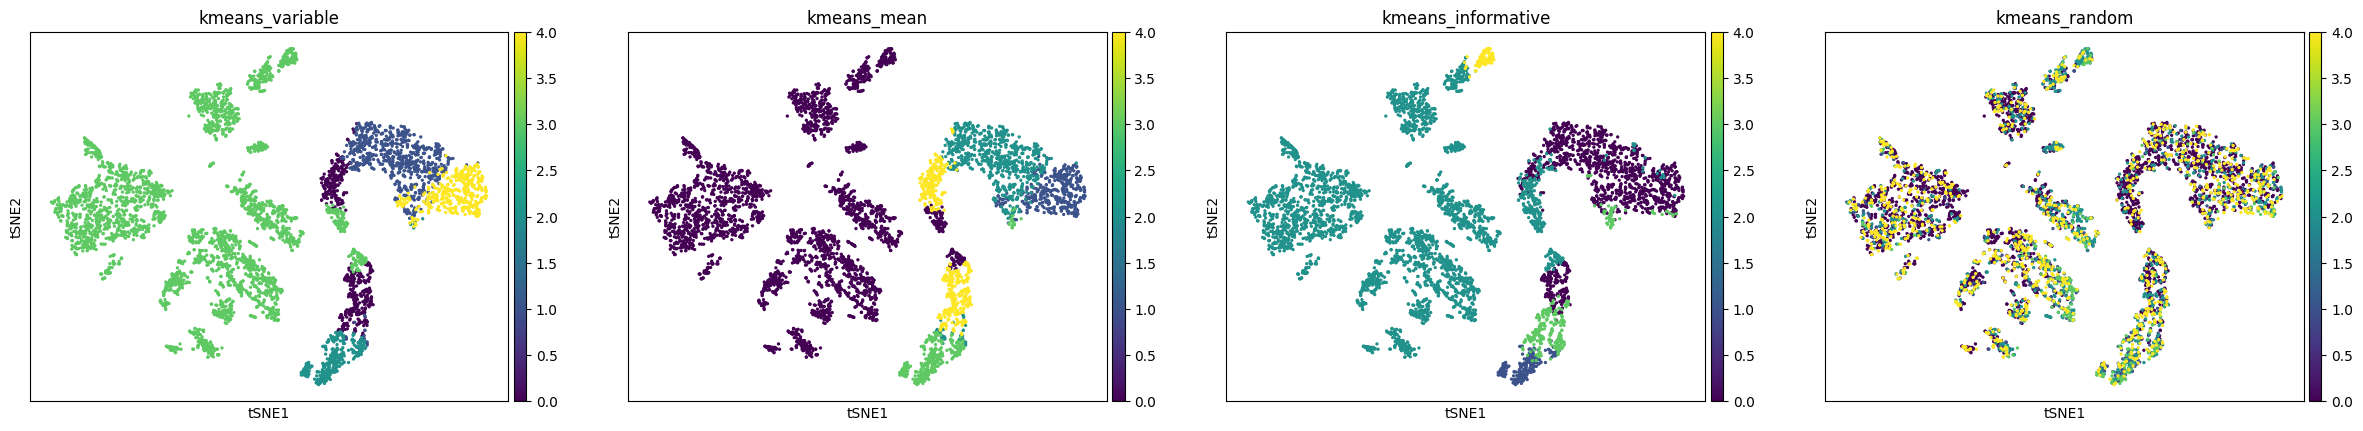

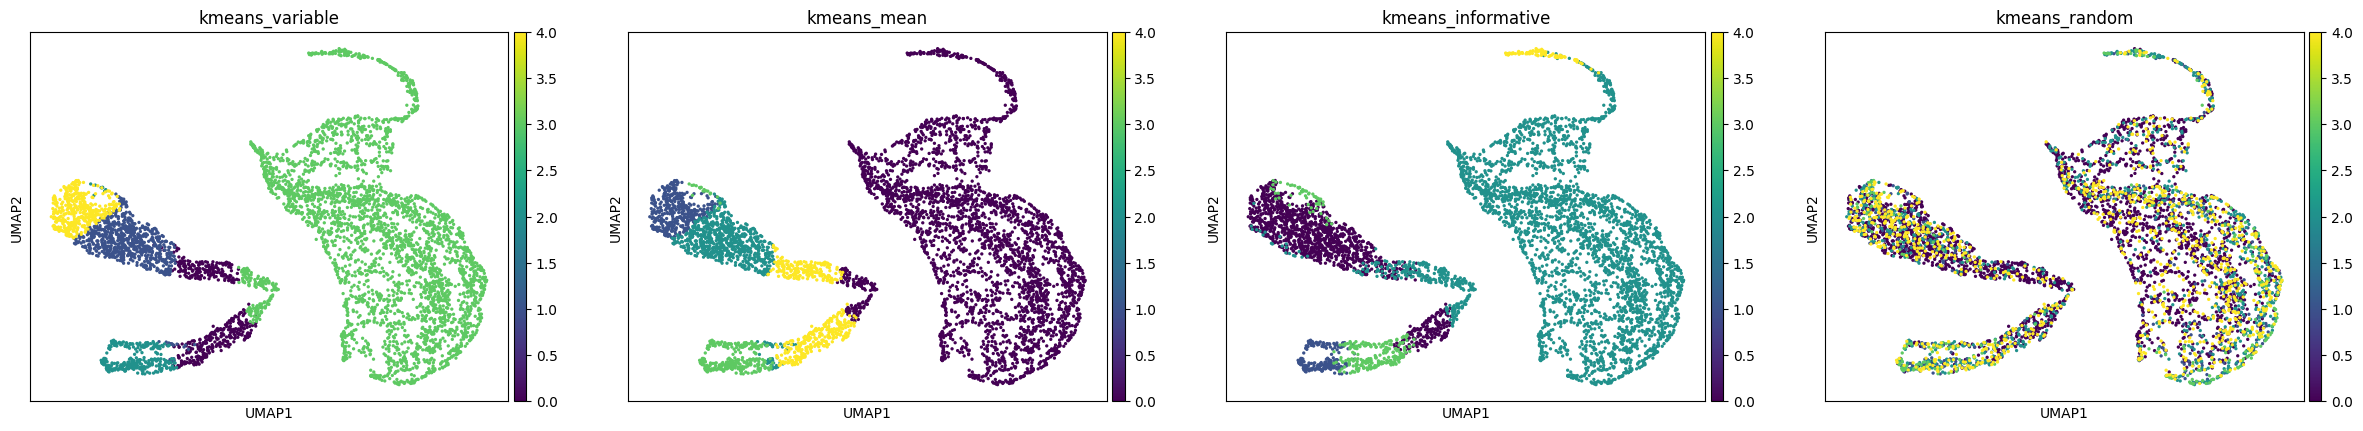

Silhouette Scores: {'variable': 0.7036697, 'mean': 0.6973193, 'informative': 0.6147262, 'random': 0.5400504}


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scanpy as sc

# Function to perform K-means clustering and add cluster labels
def perform_kmeans_clustering(adata, genes, k=5, cluster_name='cluster'):
    # Extract the expression data for the selected genes
    gene_data = adata[:, genes].X

    # Perform K-means clustering (set n_init to avoid warnings)
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(gene_data)
    labels = kmeans.labels_

    # Add the cluster labels to the AnnData object under obs
    adata.obs[cluster_name] = labels
    return labels

# Perform K-means clustering for each gene set
clusters = {
    'variable': perform_kmeans_clustering(subset_data, top_variable_genes, cluster_name='kmeans_variable'),
    'mean': perform_kmeans_clustering(subset_data, top_mean_genes, cluster_name='kmeans_mean'),
    'informative': perform_kmeans_clustering(subset_data, top_informative_genes, cluster_name='kmeans_informative'),
    'random': perform_kmeans_clustering(subset_data, random_genes, cluster_name='kmeans_random')
}

# Calculate neighbors before UMAP
sc.pp.neighbors(subset_data, n_pcs=10)  # Using the first 10 principal components for the neighborhood graph

# t-SNE visualization for each cluster
sc.tl.tsne(subset_data)
sc.pl.tsne(subset_data, color=['kmeans_variable', 'kmeans_mean', 'kmeans_informative', 'kmeans_random'])

# UMAP visualization for each cluster
sc.tl.umap(subset_data)
sc.pl.umap(subset_data, color=['kmeans_variable', 'kmeans_mean', 'kmeans_informative', 'kmeans_random'])

# Calculate silhouette score for each clustering result
silhouette_scores = {
    'variable': silhouette_score(subset_data[:, top_variable_genes].X, clusters['variable']),
    'mean': silhouette_score(subset_data[:, top_mean_genes].X, clusters['mean']),
    'informative': silhouette_score(subset_data[:, top_informative_genes].X, clusters['informative']),
    'random': silhouette_score(subset_data[:, random_genes].X, clusters['random'])
}

print("Silhouette Scores:", silhouette_scores)


(code above might is not required by the project, still including it as it's from the HW.)

In [18]:
hvg_adata = sc.pp.log1p(adata, copy=True) # Log-normalize the data
sc.pp.highly_variable_genes(hvg_adata, n_top_genes=2000) # Select highly variable genes

In [19]:
print(hvg_adata)

AnnData object with n_obs × n_vars = 5267 × 26110
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'


In [20]:
data_help = hvg_adata[:, hvg_adata.var['highly_variable']]

## PCA whitening for Leiden clustering



HW1C: Exercise 3: Leiden clustering

1. From last week, you should be able to: choose a time point in the dataset and subset the data. Make some processing choices: selection of N highly variable genes? filtering genes with low variance? log-normalization of counts?

2. Apply PCA without scaling your data. What do you see?

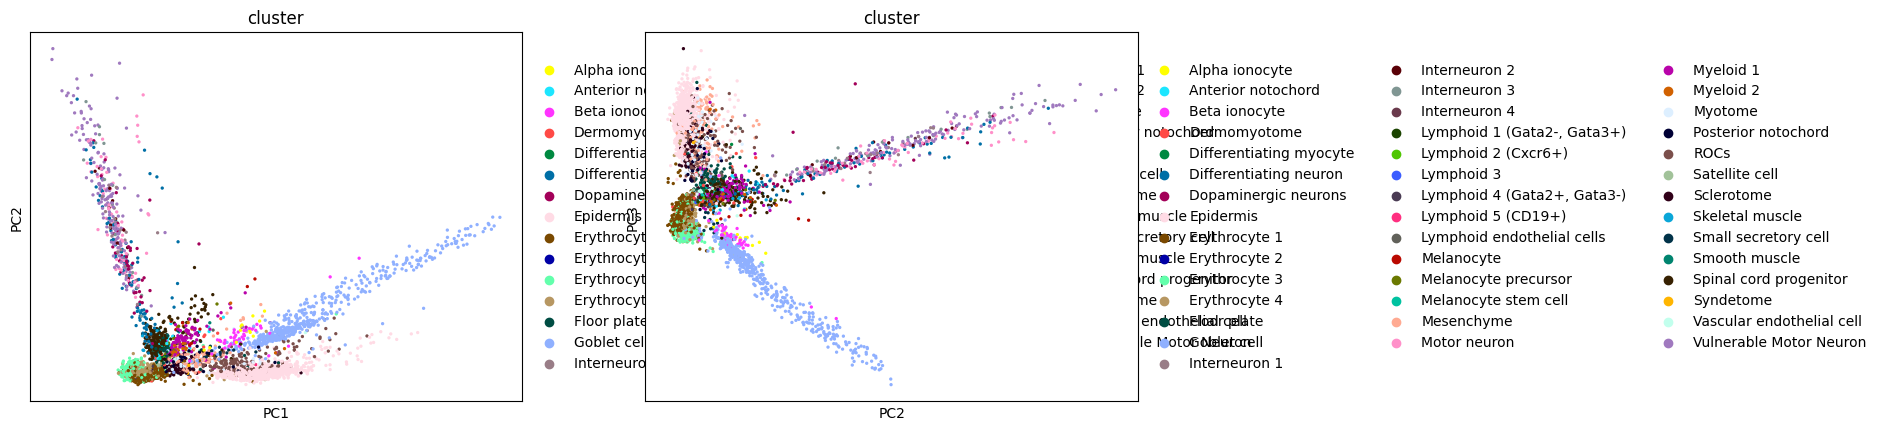

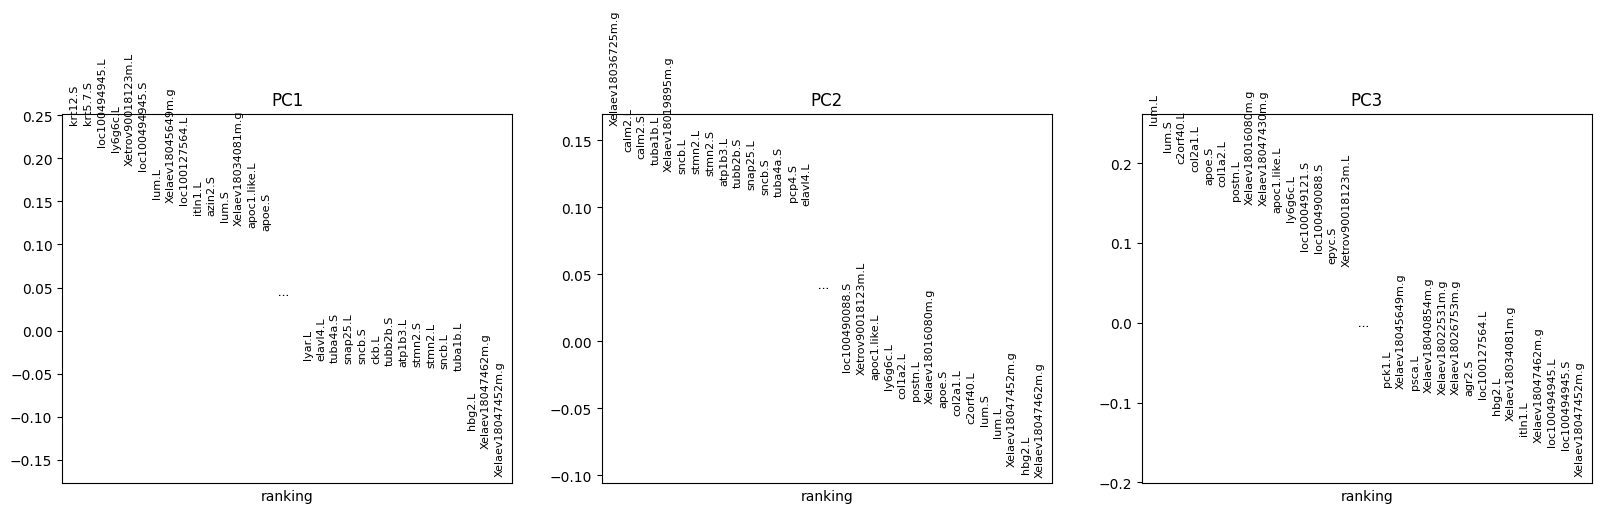

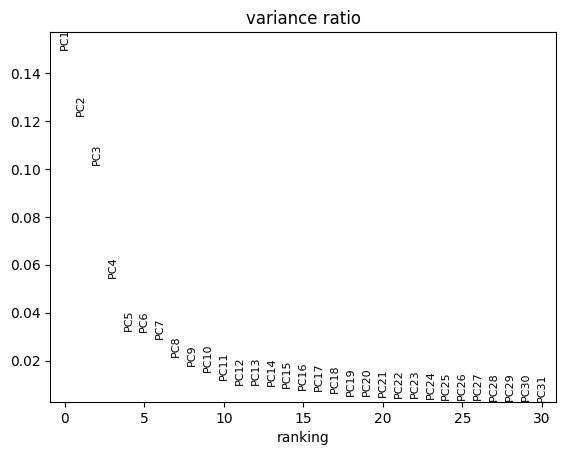

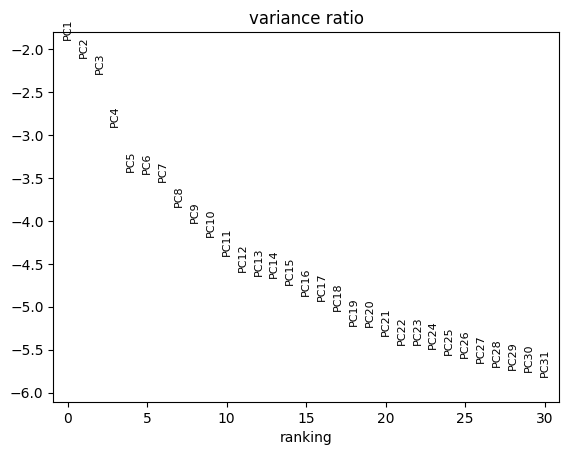

In [21]:
sc.tl.pca(hvg_adata)

sc.pl.pca_overview(hvg_adata, color='cluster', components= ['1,2', '2,3']) # Plot all diagnostics including PC1 against PC2 and PC2 against PC3
sc.pl.pca_variance_ratio(hvg_adata, log=True) # Plot the variance ratio

3. Apply PCA after scaling your data. What do you see?

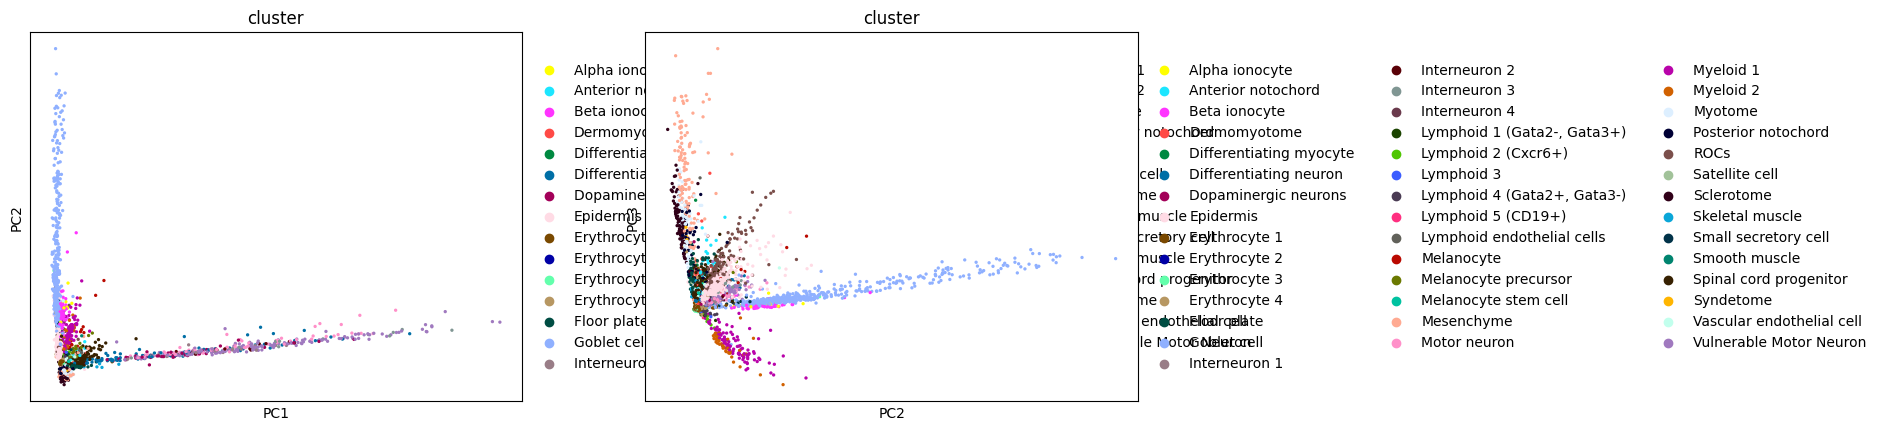

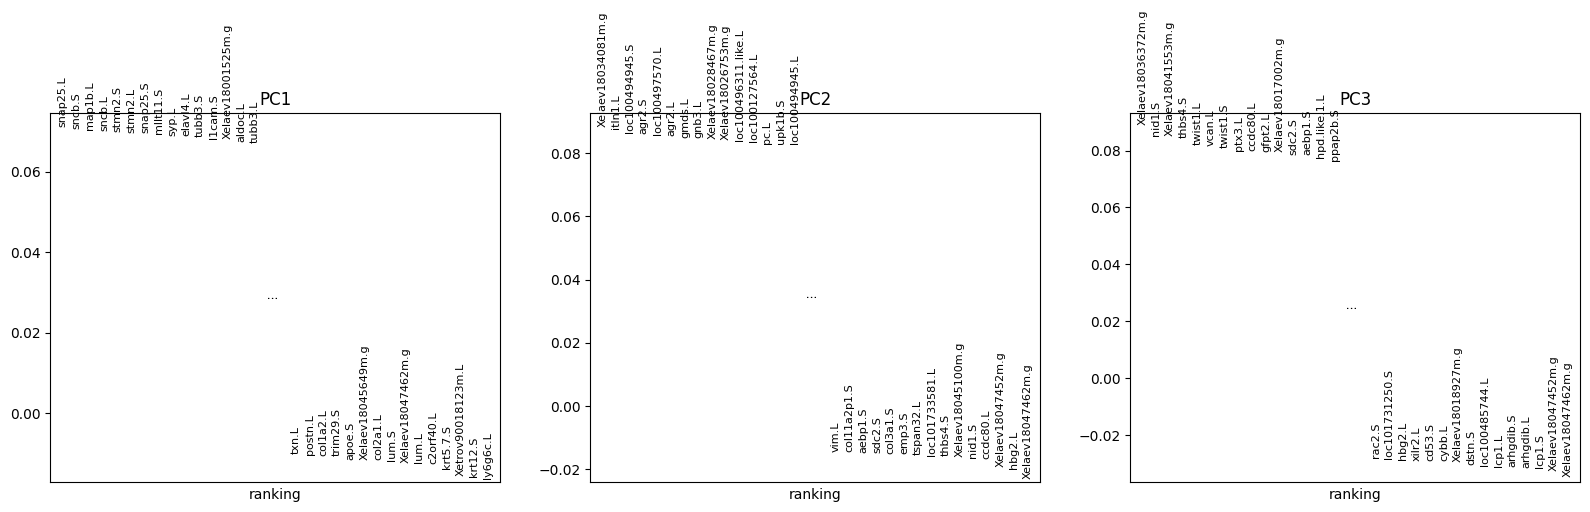

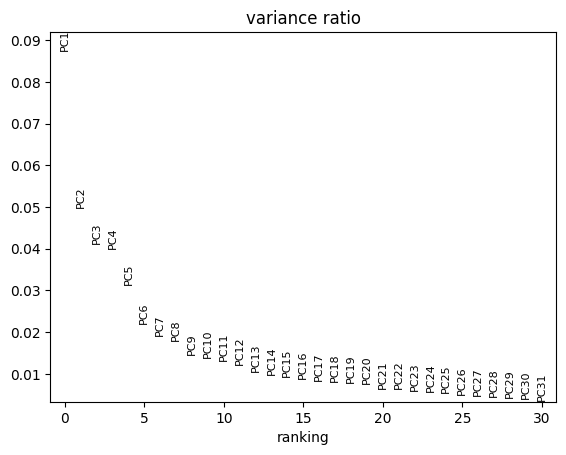

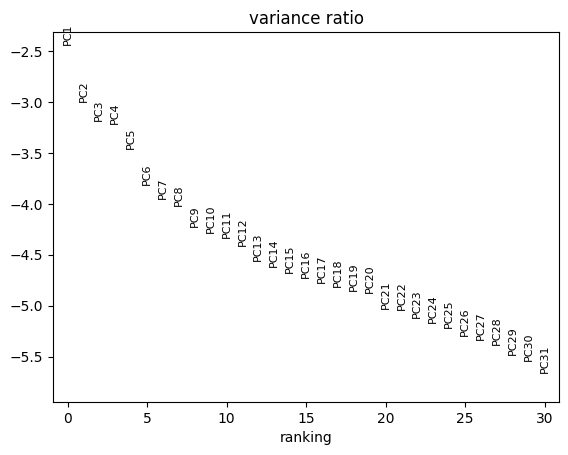

In [22]:
sc.pp.scale(hvg_adata) # Scale data

# Do PCA on the highly variable genes data - you might need to lognormalize to select HVG
sc.tl.pca(hvg_adata)
sc.pp.pca(hvg_adata) # (It's included in starter code but don't think we need it exactly, but as we're not expected to change starter code so kept it)
# (But trying to follow the starter code as that's what we got as guidence.)
sc.pl.pca_overview(hvg_adata, color='cluster', components= ['1,2', '2,3']) # Plot all diagnostics including PC1 against PC2 and PC2 against PC3
sc.pl.pca_variance_ratio(hvg_adata, log=True) # Plot the variance ratio

## Apply Leiden clustering

In [23]:
# Whitening step - create neighbors graph based on PCA
sc.pp.neighbors(hvg_adata, n_pcs=30) # Create neighbors graph - n_pcs takes the number of principal components from PCA you keep for this step
sc.tl.leiden(hvg_adata, resolution=0.5)  # Apply Leiden clustering, you can adjust the resolution parameter


<ipython-input-23-95449973a4bf>:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(hvg_adata, resolution=0.5)  # Apply Leiden clustering, you can adjust the resolution parameter


In [24]:
!pip install louvain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.2 MB/s eta 0:00:00


In [25]:
import louvain
sc.tl.louvain(hvg_adata, resolution=0.5)

<ipython-input-25-40e31515aff0>:1: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


In [26]:
print(hvg_adata)

AnnData object with n_obs × n_vars = 5267 × 26110
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'n_counts', 'leiden', 'louvain'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'cluster_colors', 'neighbors', 'leiden', 'louvain'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


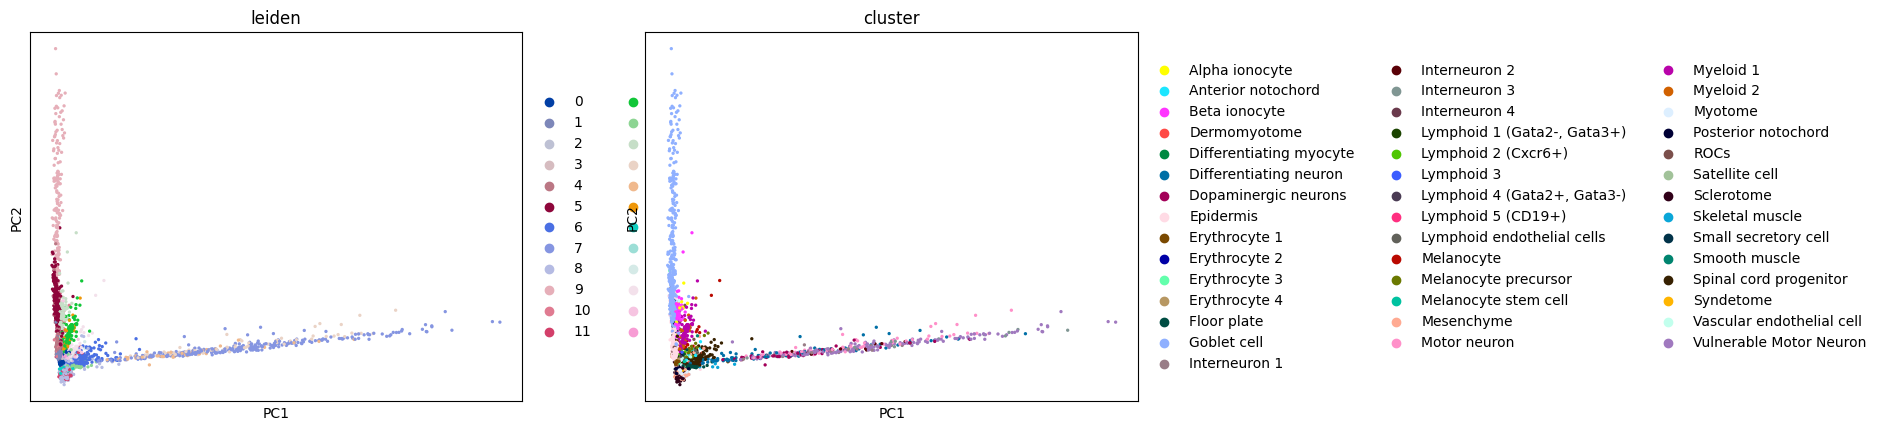

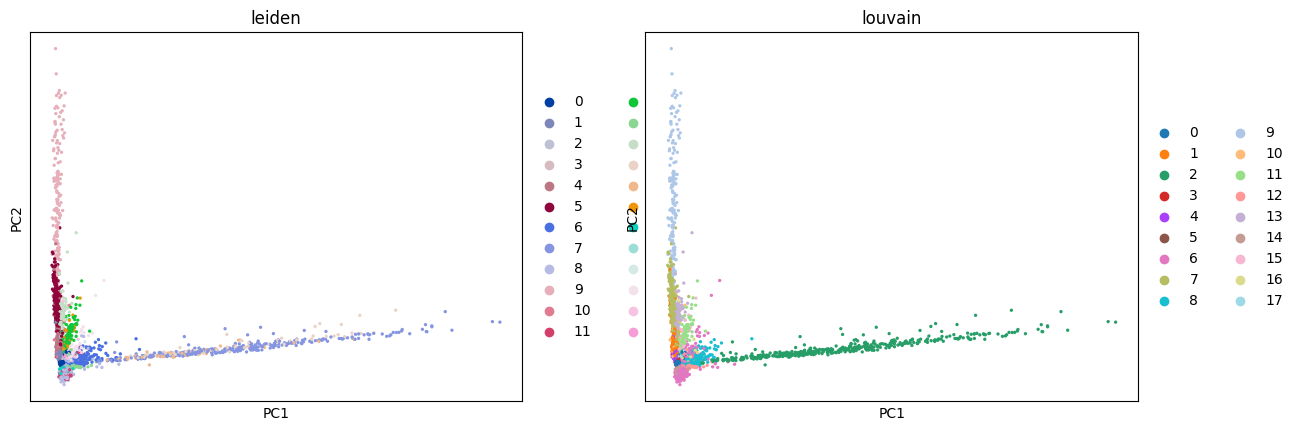

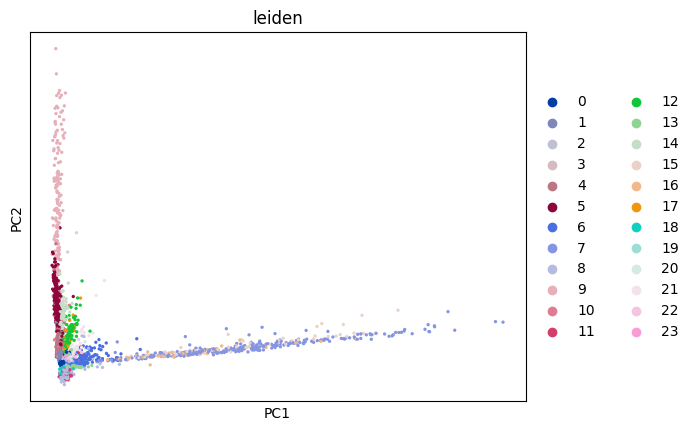

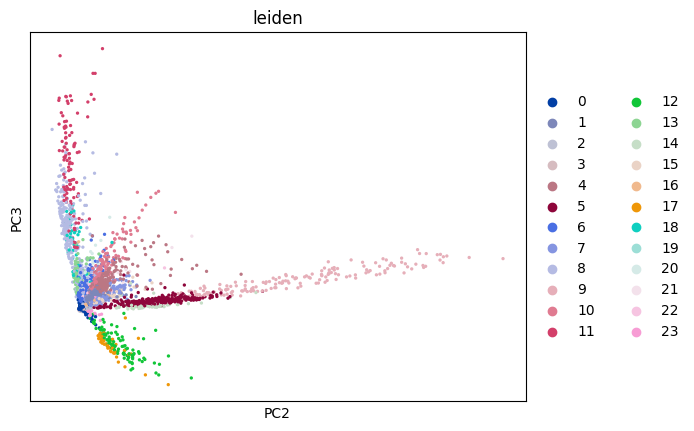

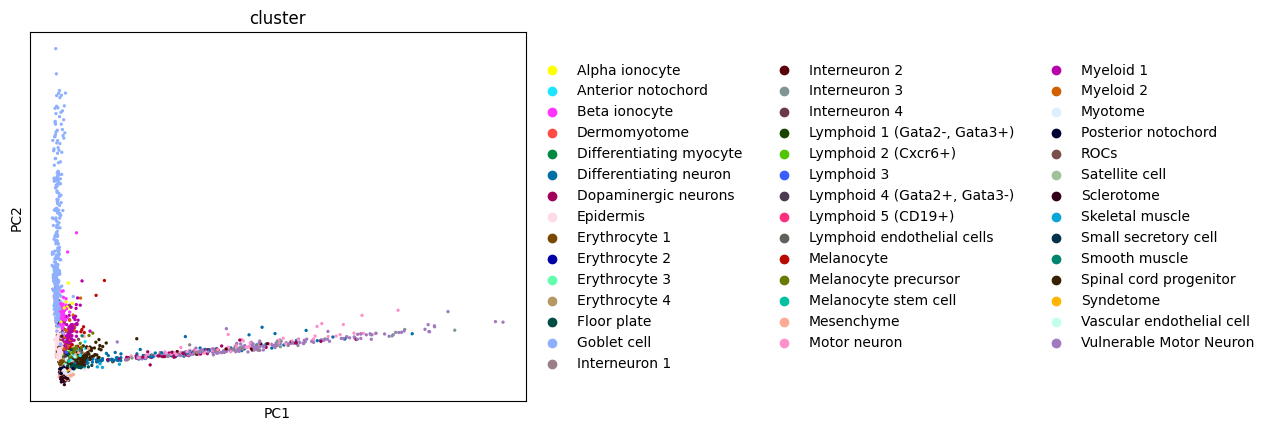

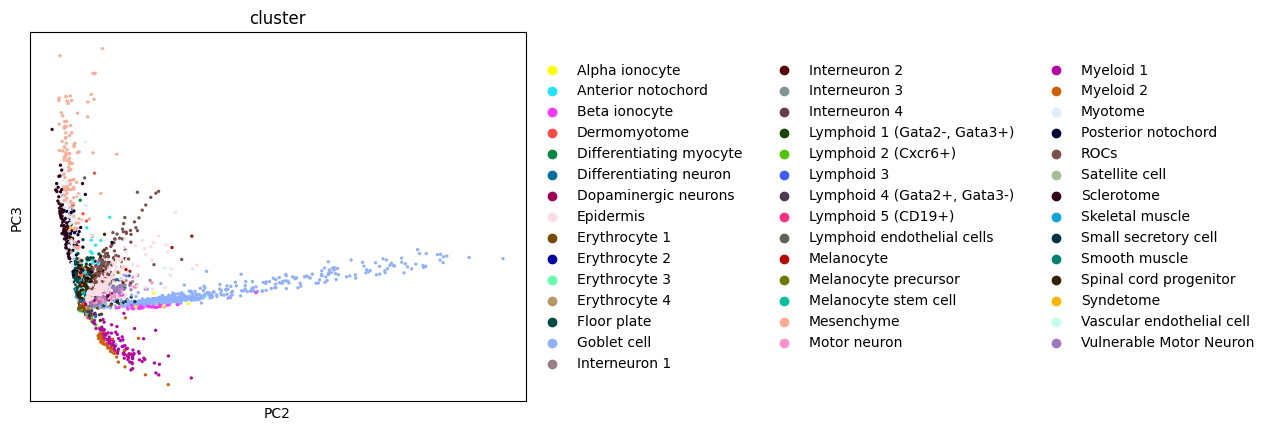

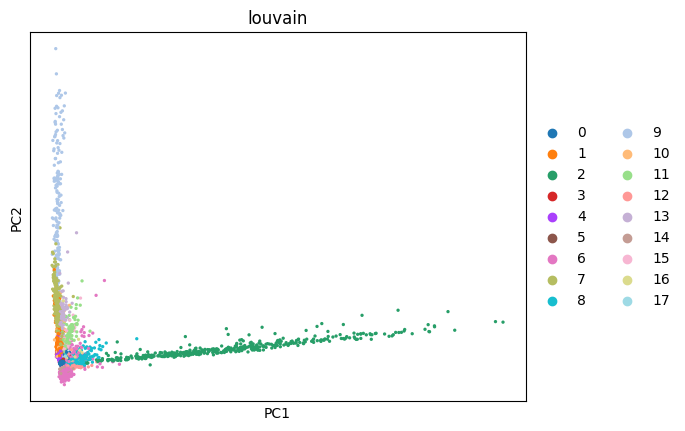

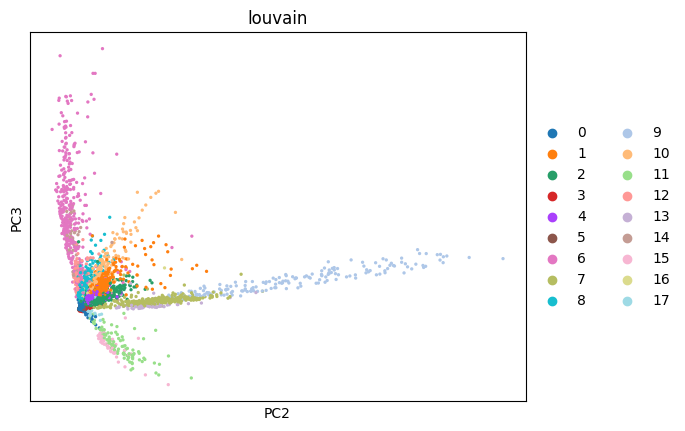

In [27]:
sc.pl.pca(hvg_adata, color=['leiden', 'cluster']) # Plotting PC1/PC2 with colors from Leiden labels
sc.pl.pca(hvg_adata, color=['leiden', 'louvain'])  # Compare Leiden and Louvain

# Plot PC1 vs PC2
sc.pl.pca_scatter(hvg_adata, components=['1,2'], color='leiden')

# Plot PC2 vs PC3
sc.pl.pca_scatter(hvg_adata, components=['2,3'], color='leiden')

# Plot PC1 vs PC2
sc.pl.pca_scatter(hvg_adata, components=['1,2'], color='cluster')

# Plot PC2 vs PC3
sc.pl.pca_scatter(hvg_adata, components=['2,3'], color='cluster')

# Plot PC1 vs PC2
sc.pl.pca_scatter(hvg_adata, components=['1,2'], color='louvain')

# Plot PC2 vs PC3
sc.pl.pca_scatter(hvg_adata, components=['2,3'], color='louvain')

In [28]:
sc.tl.tsne(hvg_adata)
sc.tl.umap(hvg_adata)

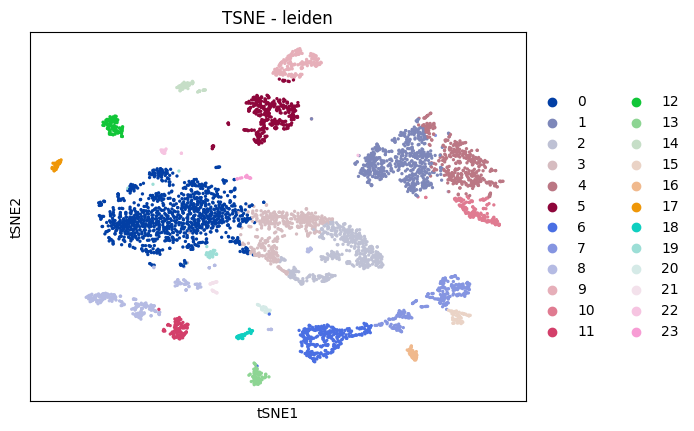

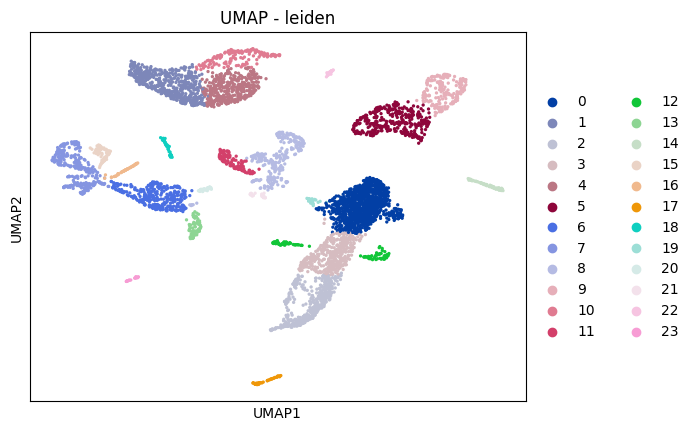

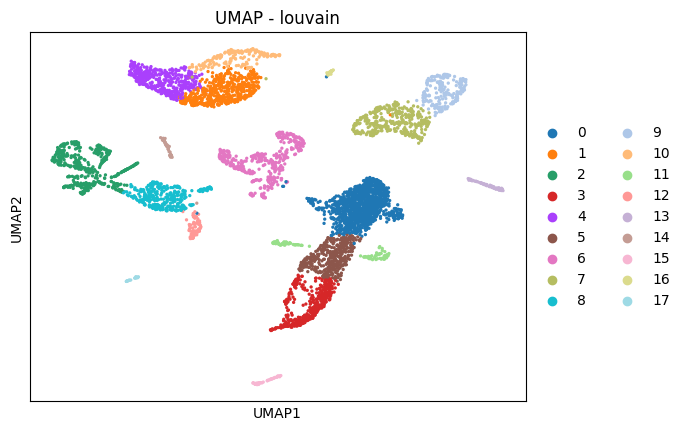

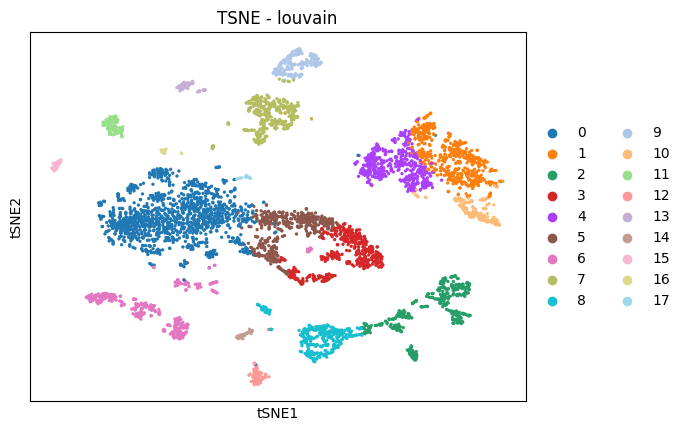

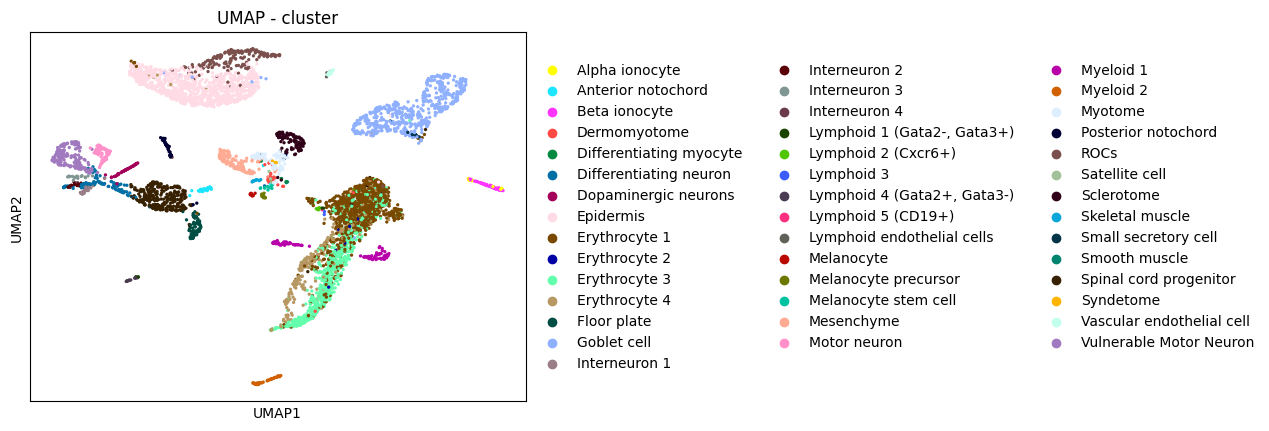

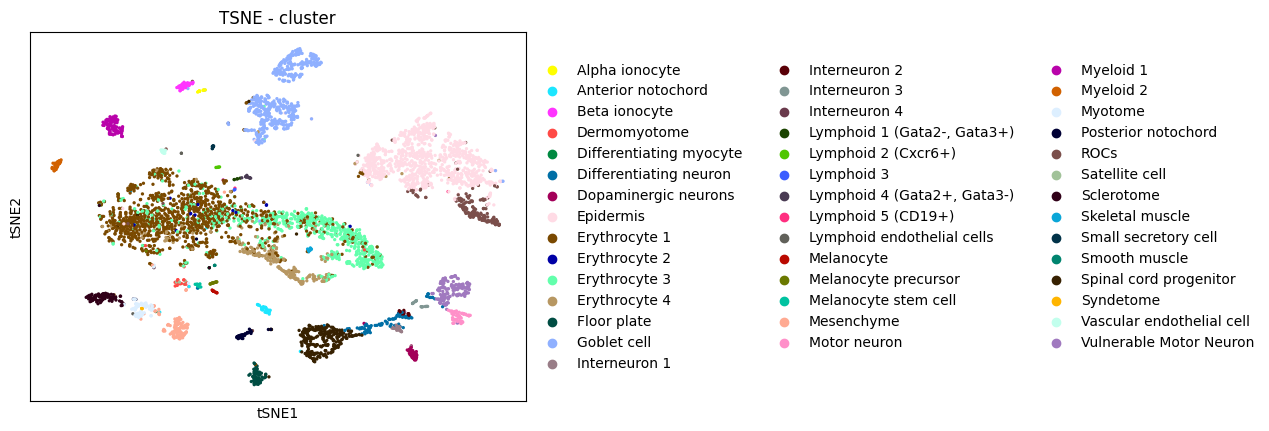

In [29]:
def plot_embedding(method, label):
    sc.pl.__dict__[method](hvg_adata, color=f'{label}', title=f'{method.upper()} - {label}')

plot_embedding('tsne', 'leiden')
plot_embedding('umap', 'leiden')

plot_embedding('umap', 'louvain')
plot_embedding('tsne', 'louvain')

plot_embedding('umap', 'cluster')
plot_embedding('tsne', 'cluster')

In [ ]:
# number of ROCs is 10

In [30]:
ari_leiden = adjusted_rand_score(hvg_adata.obs['cluster'], hvg_adata.obs['leiden'])
sil_score_leiden = silhouette_score(hvg_adata.obsm['X_pca'], hvg_adata.obs['leiden'])
fmi_leiden = fowlkes_mallows_score(hvg_adata.obs['cluster'], hvg_adata.obs['leiden'])

In [31]:
ari_louvain = adjusted_rand_score(hvg_adata.obs['cluster'], hvg_adata.obs['louvain'])
sil_score_louvain = silhouette_score(hvg_adata.obsm['X_pca'], hvg_adata.obs['louvain'])
fmi_louvain = fowlkes_mallows_score(hvg_adata.obs['cluster'], hvg_adata.obs['louvain'])

In [32]:
print("ari_leiden: ", ari_leiden)
print("sil_score_leiden: ", sil_score_leiden)
print("fmi_leiden: ", fmi_leiden)

ari_leiden:  0.5872827457429367
sil_score_leiden:  0.13604106
fmi_leiden:  0.6320811903186025


In [33]:
print("ari_louvain: ", ari_louvain)
print("sil_score_louvain: ", sil_score_louvain)
print("fmi_louvain: ", fmi_louvain)

ari_louvain:  0.5775192948986433
sil_score_louvain:  0.18360436
fmi_louvain:  0.6242998920821933


In [34]:
print(adata.obs['cluster'].value_counts())

cluster
Erythrocyte 1                  1120
Epidermis                       919
Erythrocyte 3                   671
Goblet cell                     538
Spinal cord progenitor          283
Erythrocyte 4                   272
ROCs                            174
Vulnerable Motor Neuron         172
Mesenchyme                      127
Differentiating neuron          103
Myeloid 1                        99
Sclerotome                       98
Myotome                          78
Floor plate                      77
Motor neuron                     64
Beta ionocyte                    50
Posterior notochord              50
Dopaminergic neurons             48
Myeloid 2                        46
Anterior notochord               33
Interneuron 1                    25
Dermomyotome                     22
Vascular endothelial cell        21
Interneuron 3                    18
Melanocyte precursor             16
Lymphoid 4 (Gata2+, Gata3-)      16
Erythrocyte 2                    16
Small secretory cell

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: 

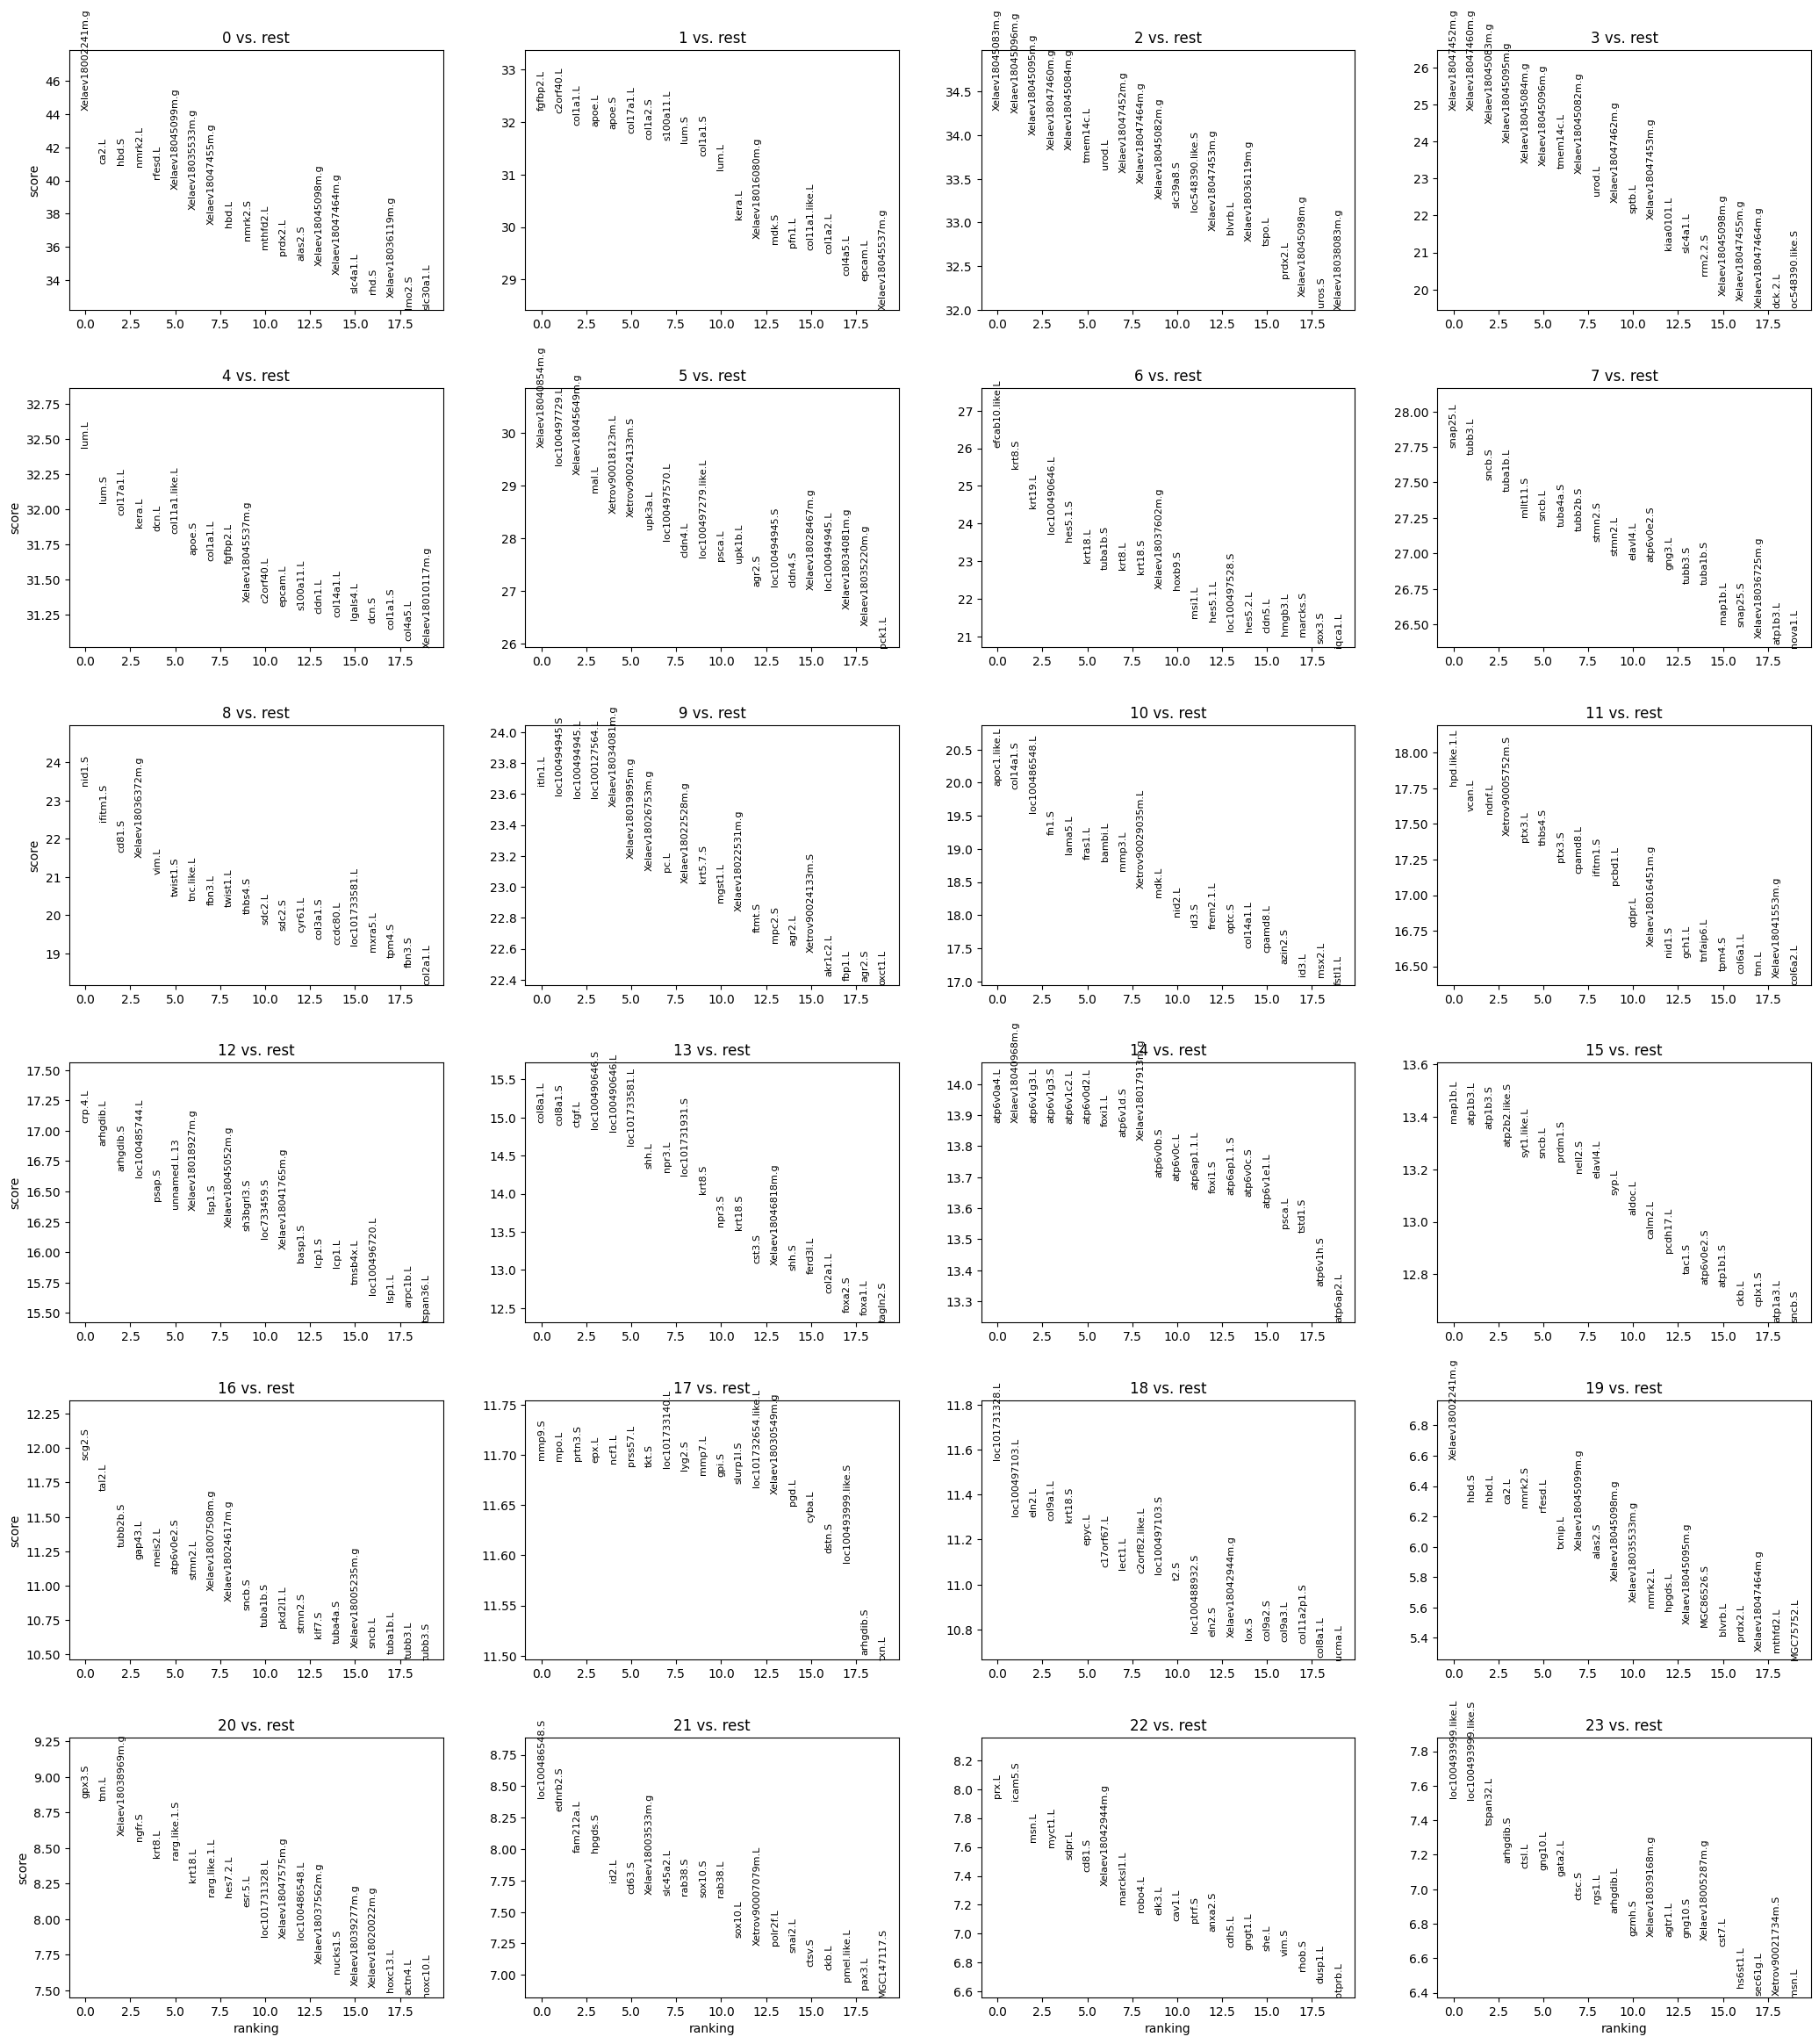

In [35]:
sc.tl.rank_genes_groups(hvg_adata, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(hvg_adata, n_genes=20, sharey=False)

In [36]:
top_50_genes_leiden = hvg_adata.uns['rank_genes_groups']['names']['10'][:50]
print(top_50_genes_leiden)

['apoc1.like.L' 'col14a1.S' 'loc100486548.L' 'fn1.S' 'lama5.L' 'fras1.L'
 'bambi.L' 'mmp3.L' 'Xetrov90029035m.L' 'mdk.L' 'nid2.L' 'id3.S'
 'frem2.1.L' 'optc.S' 'col14a1.L' 'cpamd8.L' 'azin2.S' 'id3.L' 'msx2.L'
 'fstl1.L' 'pltp.S' 'plk2.S' 'bambi.S' 'lama1.L' 'gpx3.L'
 'Xelaev18017960m.g' 'krt8.L' 'egfl6.S' 'myh9.S' 'krt5.7.S' 'btg1.L'
 'sparc.S' 'epcam.S' 'mxra5.S' 'epcam.L' 'frem2.L' 'mmp19.like.2.L'
 'bmp4.L' 'Xelaev18026267m.g' 'lamc1.S' 'egfl6.L' 'sparc.L' 'cldn6.2.S'
 'mxra5.L' 'zfp36l1.S' 'mdk.S' 'bcam.L' 'krt18.L' 'cldn1.L' 'cldn6.1.S']


In [38]:
supplementary_genes = [
    'mcm5.L', 'pcna.L', 'tyms.L', 'fen1.L', 'mcm2.L', 'mcm4.L', 'rrm1.L', 'ung.L',
    'gins2.L', 'mcm6.L', 'cdca7.L', 'dtl.L', 'prim1.L', 'uhrf1.L', 'cenpu.L', 'hells.L',
    'rfc2.L', 'rpa2.L', 'nasp.L', 'rad51ap1.L', 'gmnn.L', 'wdr76.L', 'slbp.L', 'ccne2.L',
    'ubr7.L', 'pold3.L', 'msh2.L', 'atad2.L', 'rad51.L', 'rrm2.2.L', 'cdc45.L', 'exo1.L',
    'tipin.L', 'dscc1.L', 'blm.L', 'casp8ap2.L', 'usp1.L', 'clspn.L', 'pola1.L', 'chaf1b.L',
    'brip1.L', 'e2f8.L', 'mcm5.S', 'pcna.S', 'tyms.S', 'fen1.S', 'mcm2.S', 'mcm4.S',
    'rrm1.S', 'ung.S', 'gins2.S', 'mcm6.S', 'cdca7.S', 'dtl.S', 'prim1.S', 'uhrf1.S',
    'cenpu.S', 'hells.S', 'rfc2.S', 'rpa2.S', 'nasp.S', 'rad51ap1.S', 'gmnn.S', 'wdr76.S',
    'slbp.S', 'ccne2.S', 'ubr7.S', 'pold3.S', 'msh2.S', 'atad2.S', 'rad51.S', 'rrm2.2.S',
    'cdc45.S', 'exo1.S', 'tipin.S', 'dscc1.S', 'blm.S', 'casp8ap2.S', 'usp1.S', 'clspn.S',
    'pola1.S', 'chaf1b.S', 'brip1.S', 'e2f8.S'
]


# Intersection
common_genes = set(top_50_genes_leiden).intersection(supplementary_genes)
print(f"Common genes between ROC and Supplementary Table 3: {common_genes}")


Common genes between ROC and Supplementary Table 3: set()


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: 

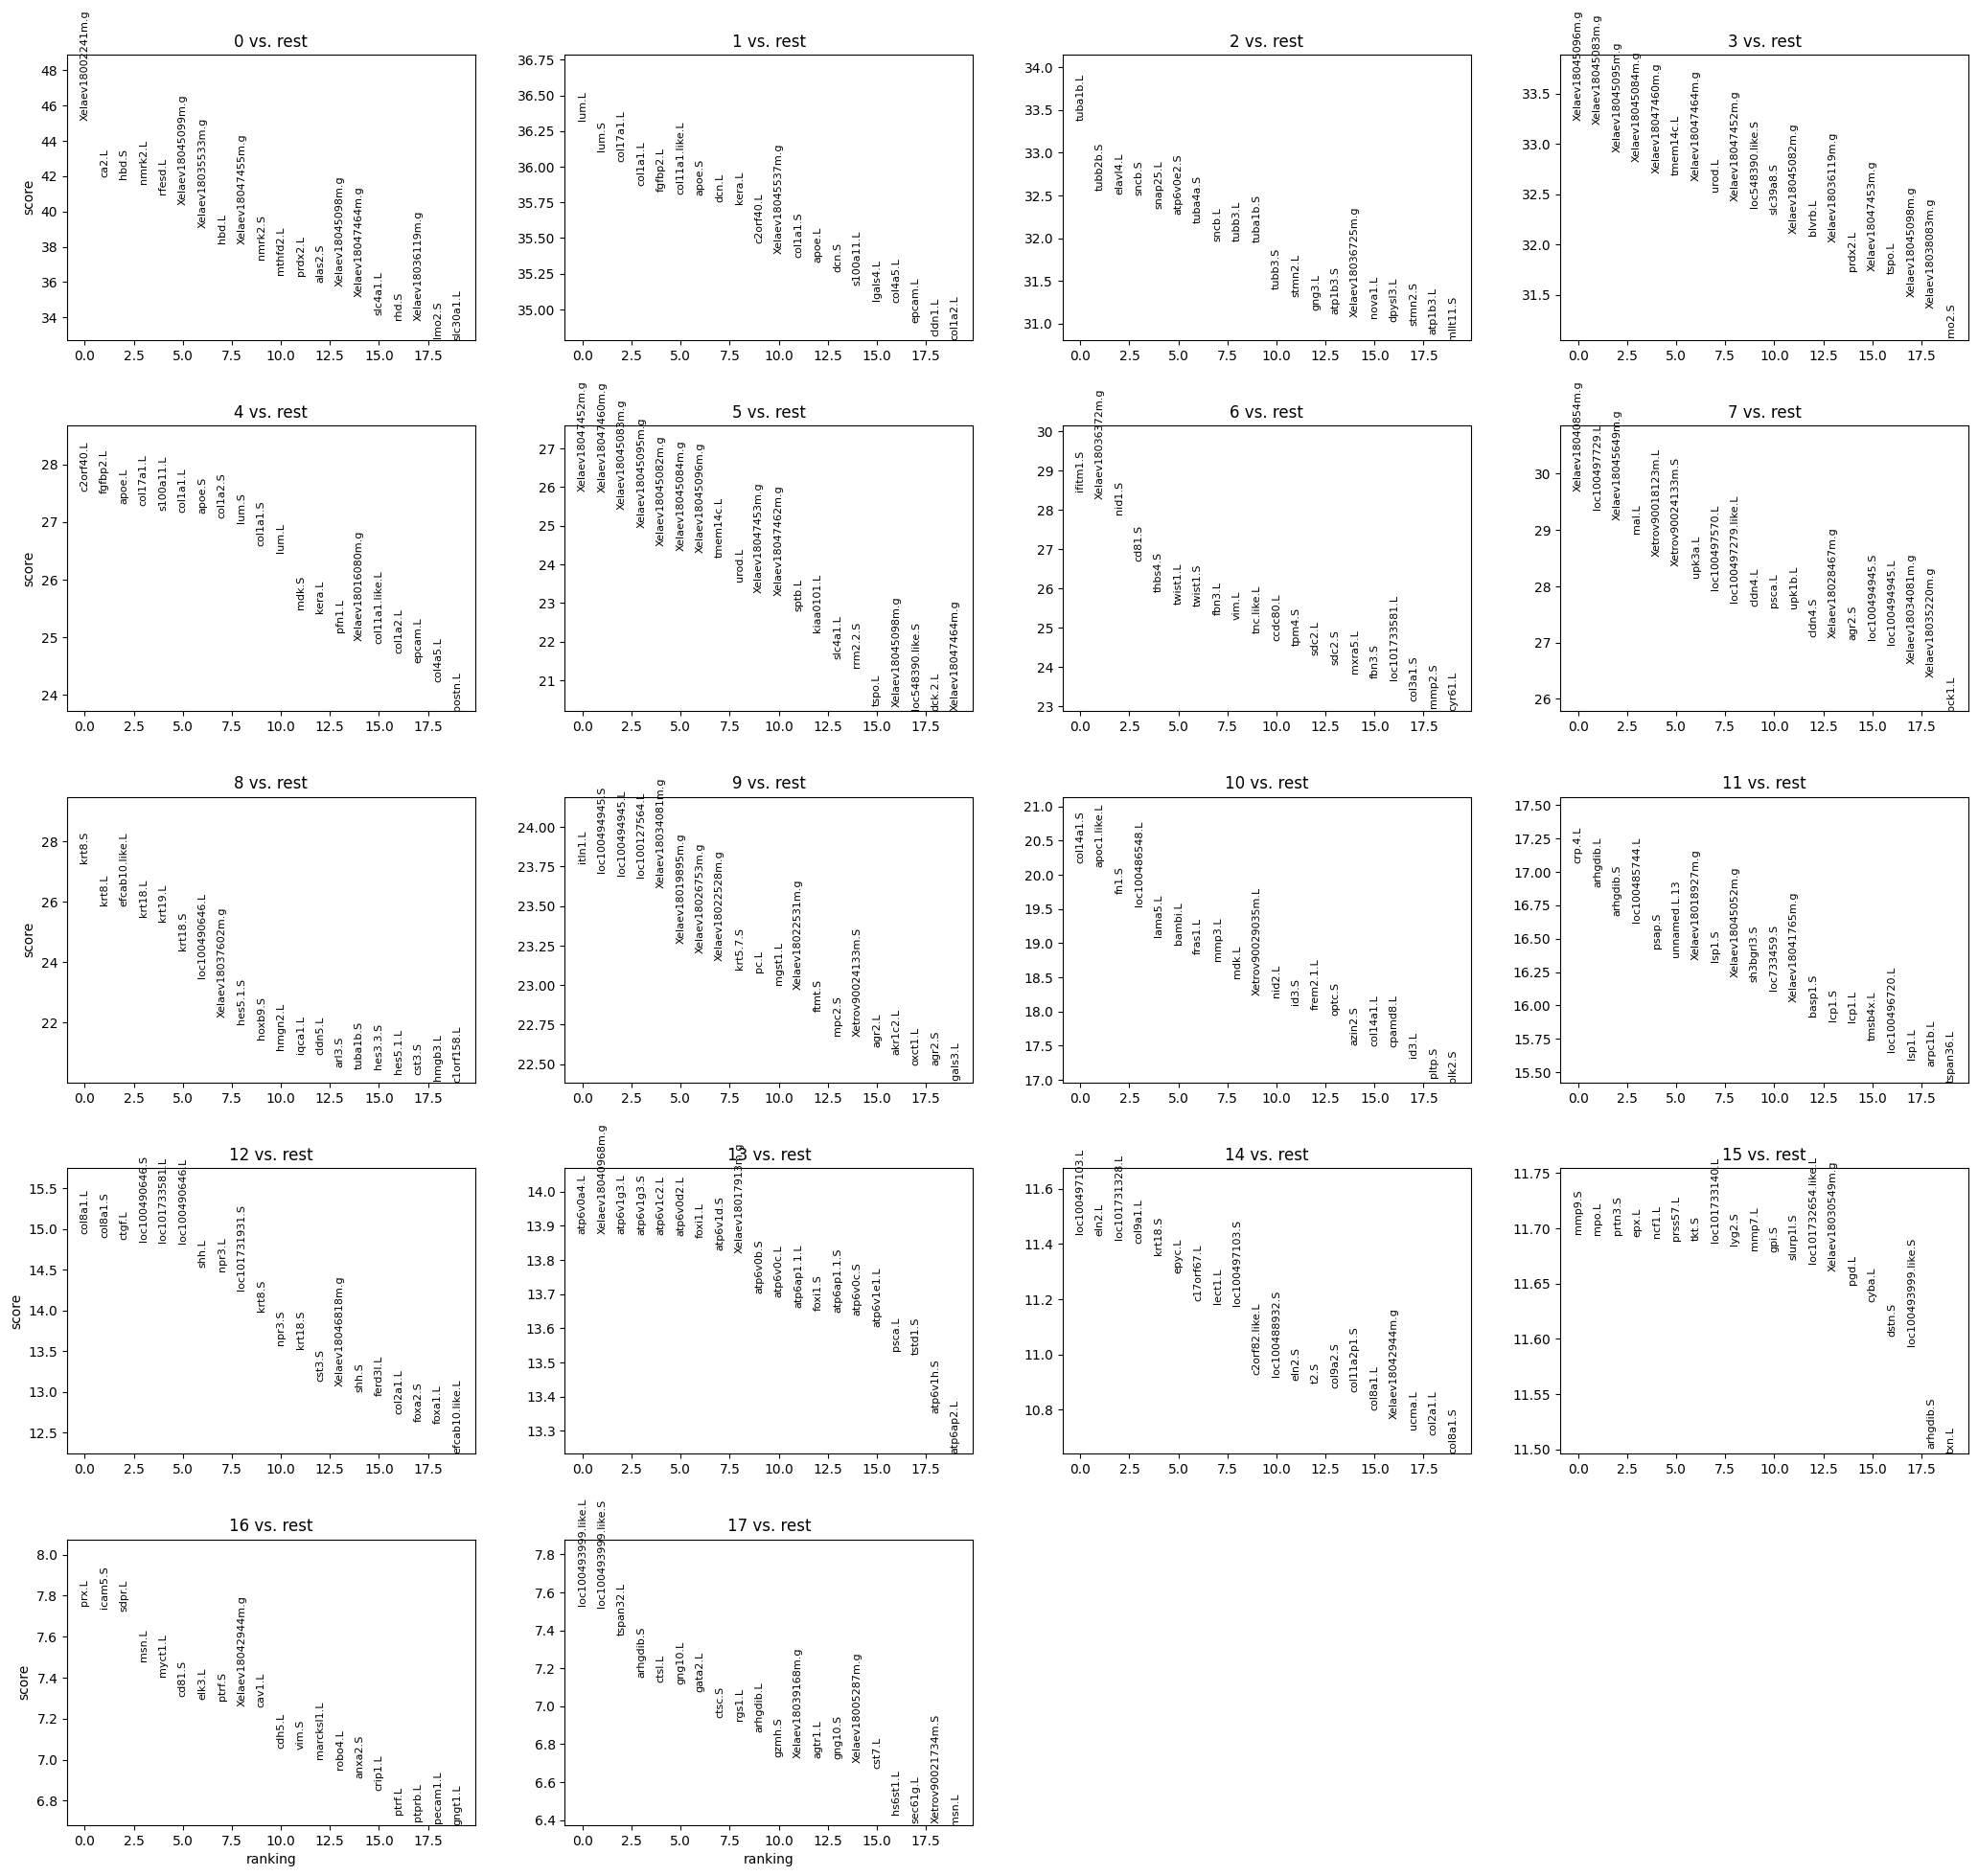

In [39]:
sc.tl.rank_genes_groups(hvg_adata, groupby='louvain', method='wilcoxon')
sc.pl.rank_genes_groups(hvg_adata, n_genes=20, sharey=False)

In [40]:
top_50_genes_louvain = hvg_adata.uns['rank_genes_groups']['names']['10'][:50]
print(top_50_genes_louvain)

['col14a1.S' 'apoc1.like.L' 'fn1.S' 'loc100486548.L' 'lama5.L' 'bambi.L'
 'fras1.L' 'mmp3.L' 'mdk.L' 'Xetrov90029035m.L' 'nid2.L' 'id3.S'
 'frem2.1.L' 'optc.S' 'azin2.S' 'col14a1.L' 'cpamd8.L' 'id3.L' 'pltp.S'
 'plk2.S' 'msx2.L' 'fstl1.L' 'lama1.L' 'gpx3.L' 'bambi.S'
 'Xelaev18017960m.g' 'egfl6.S' 'krt8.L' 'myh9.S' 'krt5.7.S' 'btg1.L'
 'epcam.S' 'sparc.S' 'epcam.L' 'mxra5.S' 'mmp19.like.2.L' 'frem2.L'
 'Xelaev18026267m.g' 'bmp4.L' 'cldn6.2.S' 'zfp36l1.S' 'mdk.S' 'lamc1.S'
 'sparc.L' 'bcam.L' 'cldn6.1.S' 'krt18.L' 'egfl6.L' 'hes4.L' 'mxra5.L']


In [41]:
# Intersection
common_genes_louvain = set(top_50_genes_louvain).intersection(supplementary_genes)
print(f"Common genes between ROC and Supplementary Table 3: {common_genes_louvain}")

Common genes between ROC and Supplementary Table 3: set()


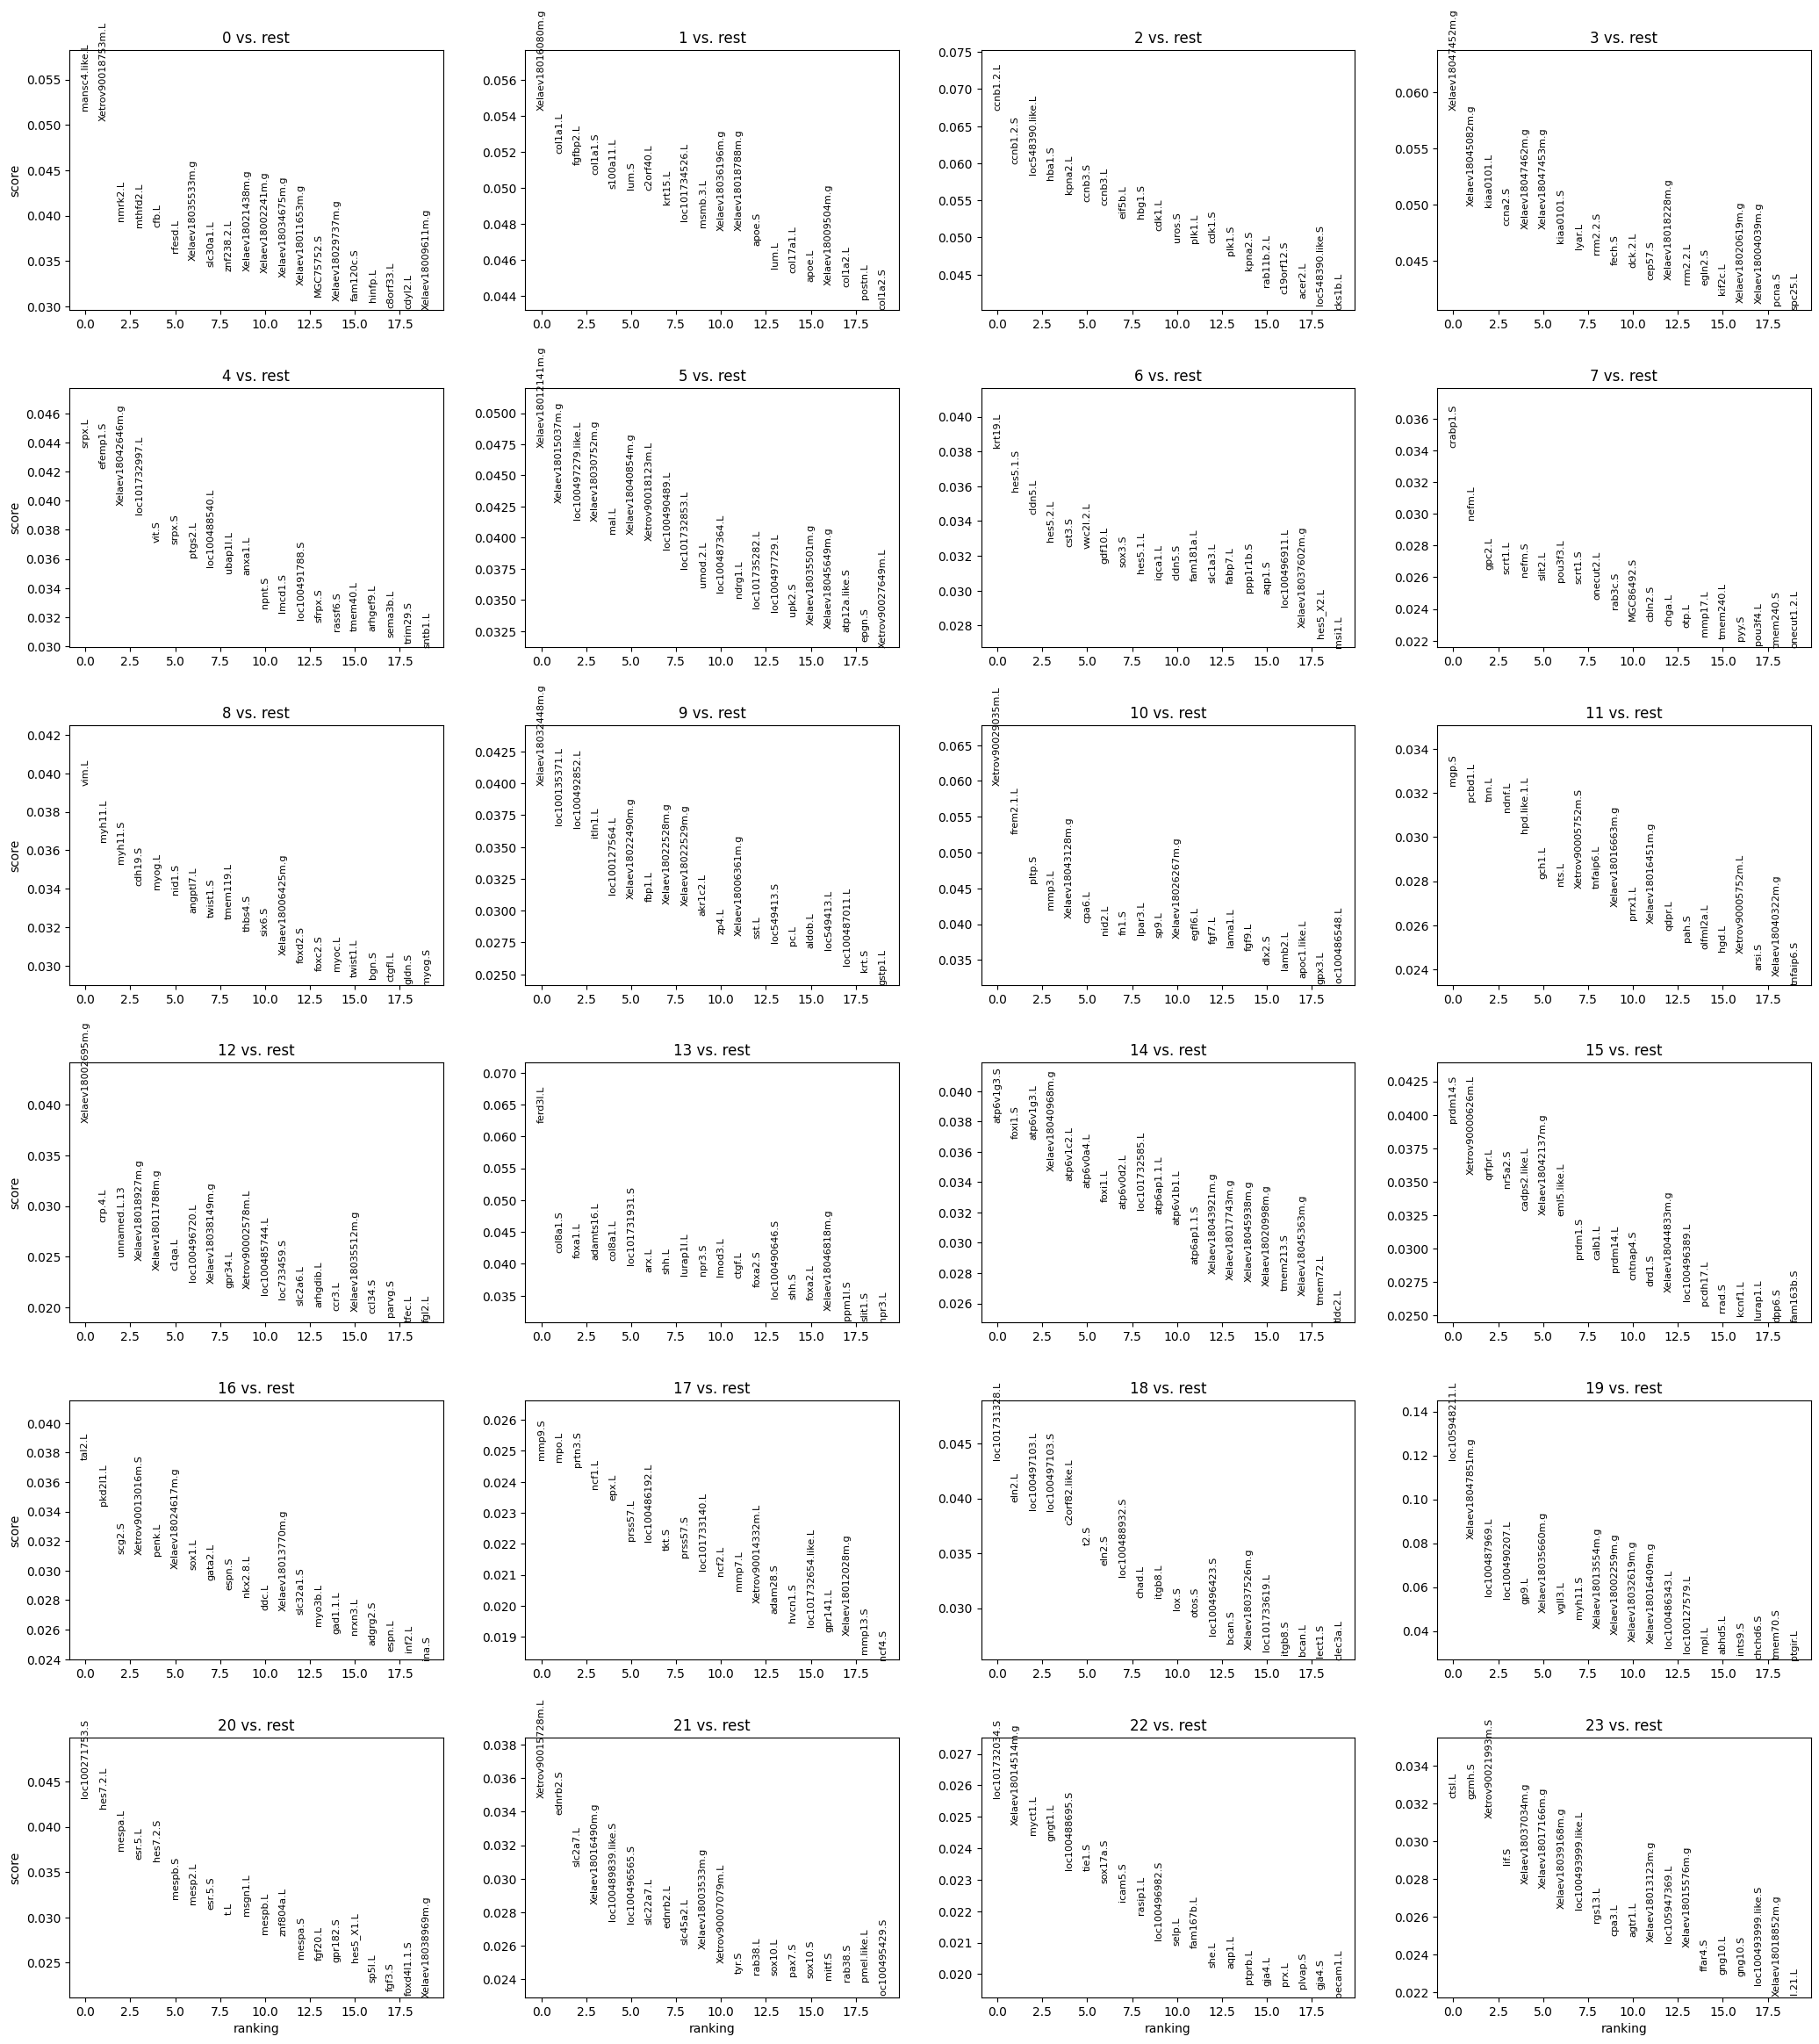

['Xetrov90029035m.L' 'frem2.1.L' 'pltp.S' 'mmp3.L' 'Xelaev18043128m.g'
 'cpa6.L' 'nid2.L' 'fn1.S' 'lpar3.L' 'sp9.L' 'Xelaev18026267m.g' 'egfl6.L'
 'fgf7.L' 'lama1.L' 'fgf9.L' 'dlx2.S' 'lamb2.L' 'apoc1.like.L' 'gpx3.L'
 'loc100486548.L' 'mxra5.S' 'cpa6.S' 'bambi.L' 'fgf7.S' 'optc.S' 'pnhd.L'
 'dlx2.L' 'Xelaev18019857m.g' 'lama5.L' 'fras1.L' 'Xelaev18017960m.g'
 'rspo2.L' 'bmp4.L' 'vwde.L' 'loc100127750.S' 'bambi.S'
 'Xelaev18046800m.g' 'col14a1.S' 'hmcn1.L' 'cldn6.2.S' 'fstl1.L'
 'tinagl1.S' 'ermn.L' 'fbn2.S' 'krt.L' 'krt18.L' 'prdm1.L' 'krt8.L'
 'cldn6.1.S' 'pltp.L']


In [42]:
# Run logistic regression for marker identification
sc.tl.rank_genes_groups(hvg_adata, groupby='leiden', method='logreg', key_added='logreg')

# View the identified marker genes
sc.pl.rank_genes_groups(hvg_adata, n_genes=20, sharey=False, key='logreg')

# Save the results in a pandas DataFrame for further analysis
logreg_genes_df = pd.DataFrame(hvg_adata.uns['logreg']['names'])

# For cluster 10, let's print the top 20 marker genes
logreg_genes_leiden = hvg_adata.uns['logreg']['names']['10'][:50]
print(logreg_genes_leiden)

In [44]:
overlap_logreg_leiden = set(logreg_genes_leiden).intersection(supplementary_genes)
print(f"Overlapping genes between logistic regression markers and Supplementary Table 3: {overlap_logreg_leiden}")

Overlapping genes between logistic regression markers and Supplementary Table 3: set()


In [45]:
overlap_logreg_w = set(logreg_genes_leiden).intersection(top_50_genes_leiden)
print(f"Overlapping genes between logistic regression markers and ROC from previous step: {overlap_logreg_w}")

Overlapping genes between logistic regression markers and ROC from previous step: {'cldn6.2.S', 'mmp3.L', 'col14a1.S', 'fn1.S', 'nid2.L', 'frem2.1.L', 'Xetrov90029035m.L', 'fstl1.L', 'krt18.L', 'egfl6.L', 'bmp4.L', 'loc100486548.L', 'optc.S', 'lama1.L', 'Xelaev18026267m.g', 'pltp.S', 'lama5.L', 'krt8.L', 'apoc1.like.L', 'fras1.L', 'mxra5.S', 'bambi.L', 'bambi.S', 'gpx3.L', 'cldn6.1.S', 'Xelaev18017960m.g'}


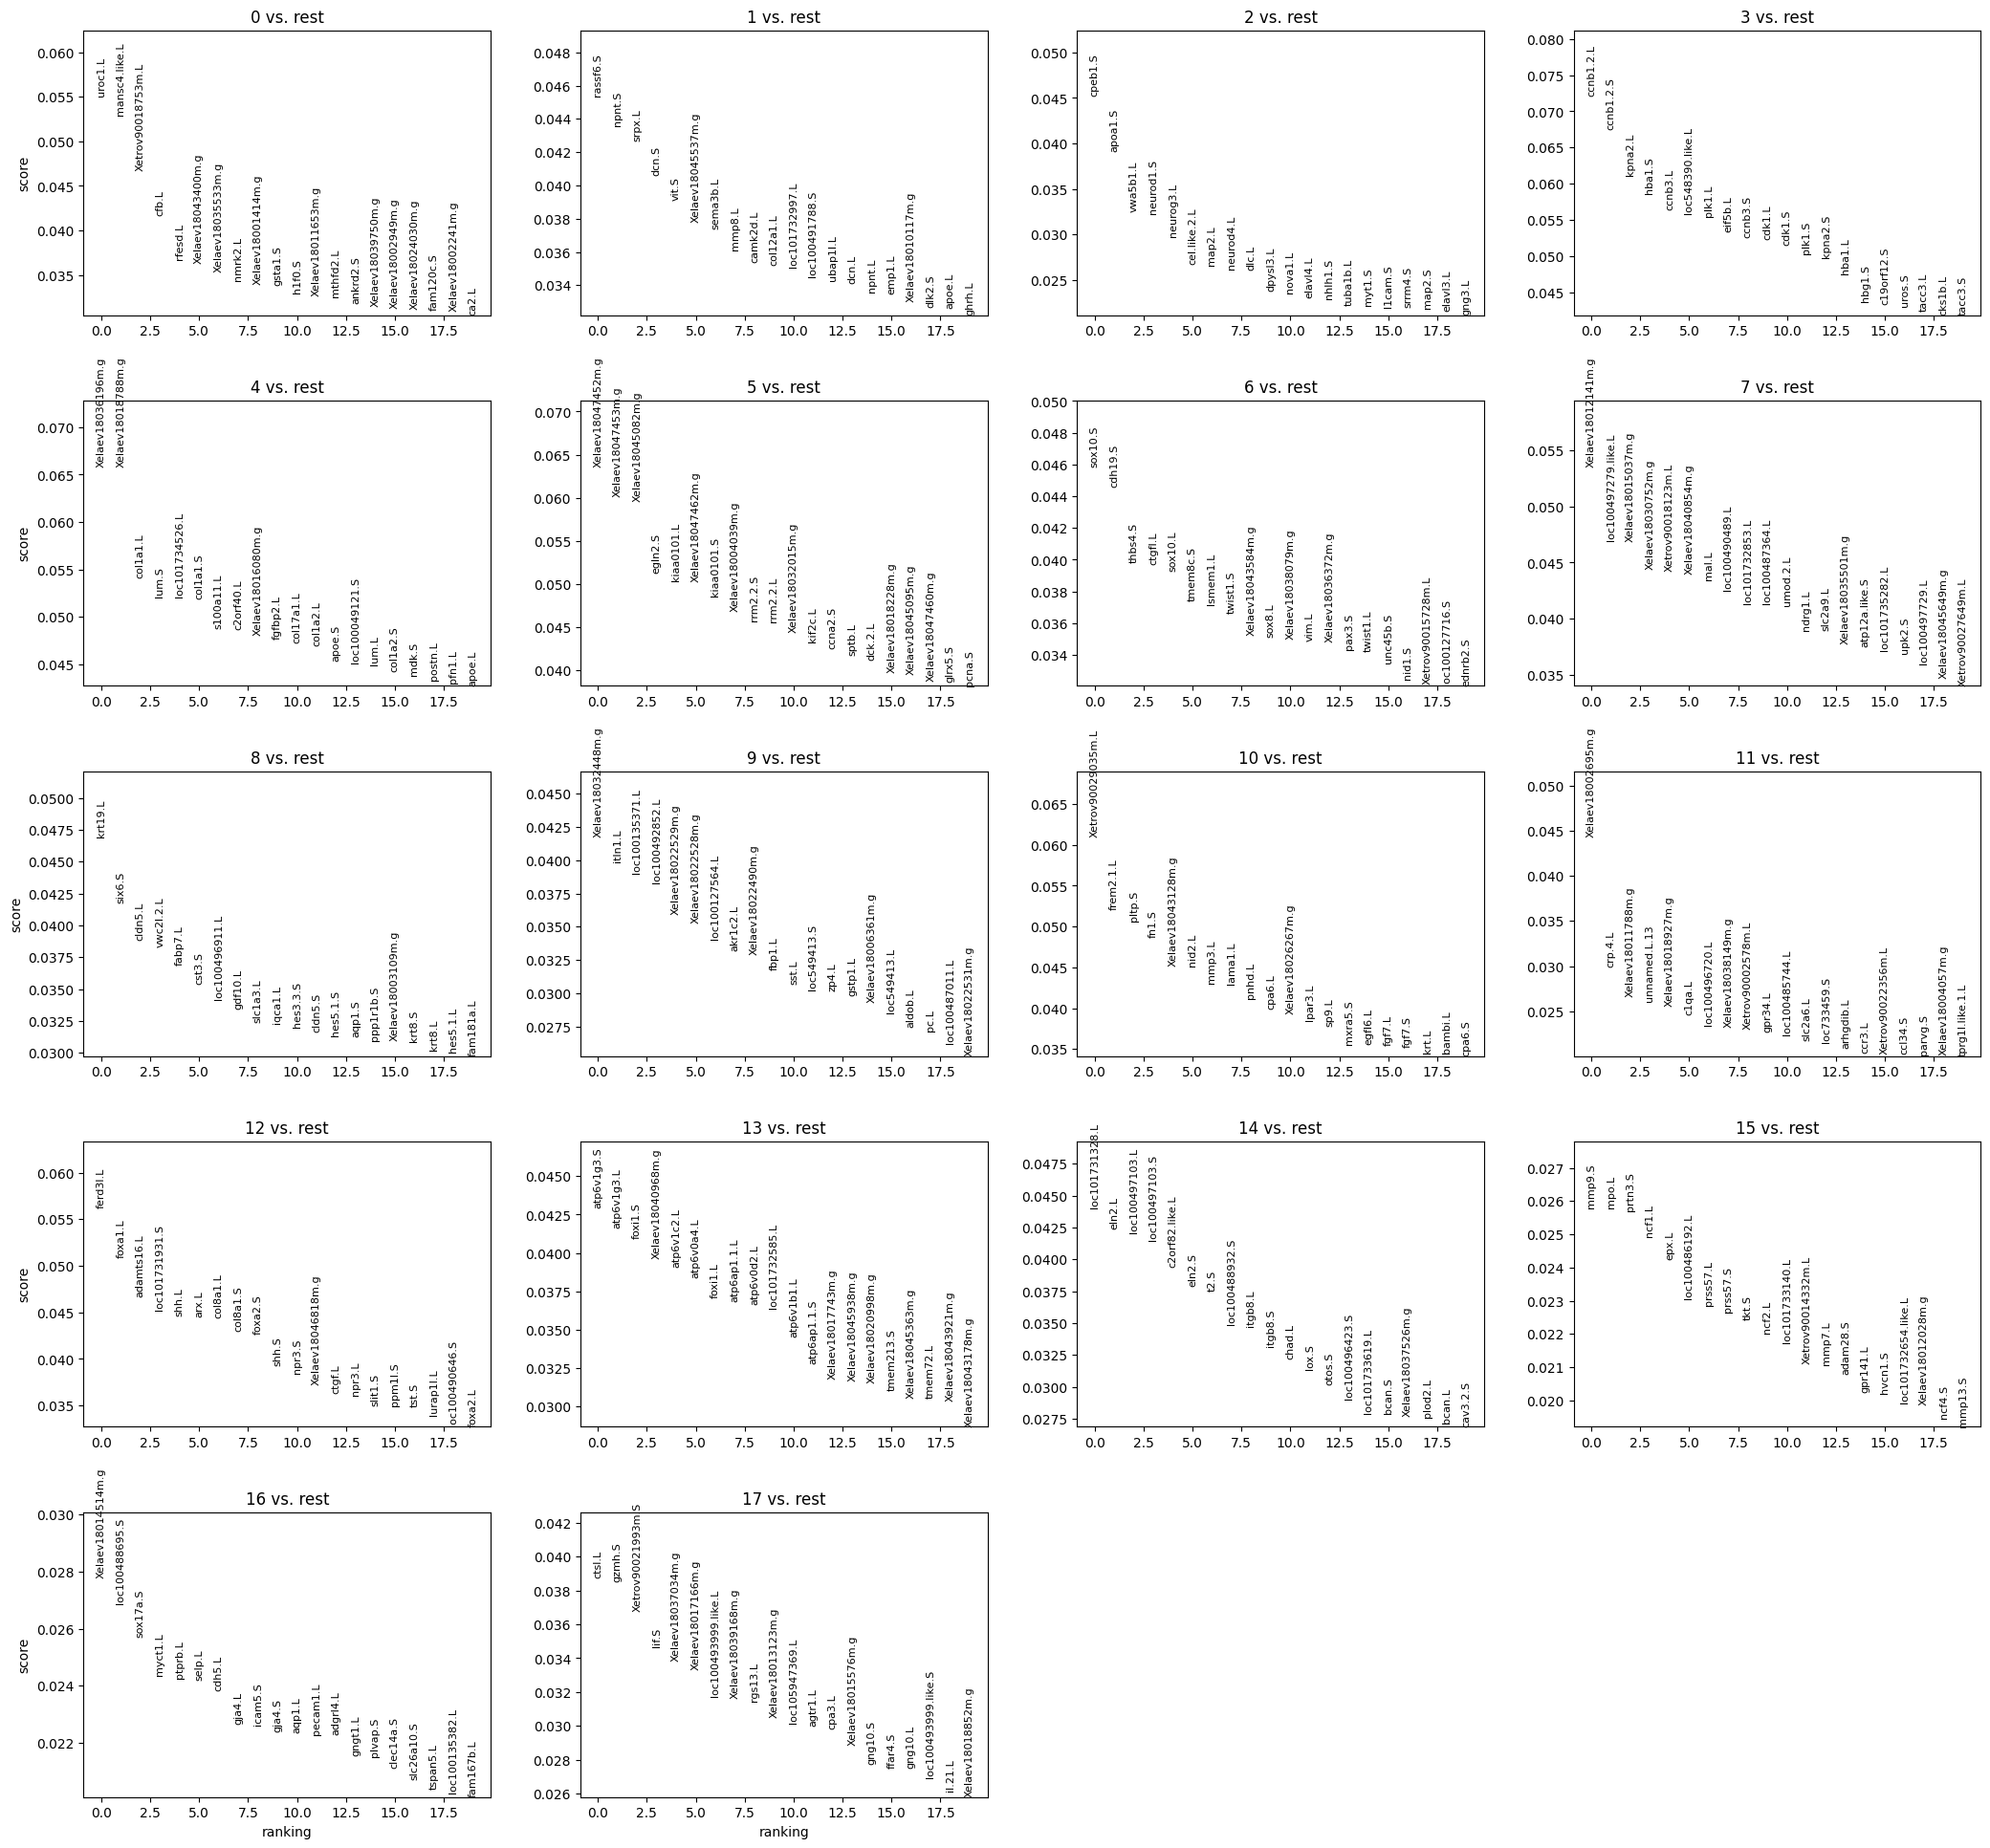

['Xetrov90029035m.L' 'frem2.1.L' 'pltp.S' 'fn1.S' 'Xelaev18043128m.g'
 'nid2.L' 'mmp3.L' 'lama1.L' 'pnhd.L' 'cpa6.L' 'Xelaev18026267m.g'
 'lpar3.L' 'sp9.L' 'mxra5.S' 'egfl6.L' 'fgf7.L' 'fgf7.S' 'krt.L' 'bambi.L'
 'cpa6.S' 'fgf9.L' 'lamb2.L' 'apoc1.like.L' 'loc100486548.L' 'optc.S'
 'dlx2.L' 'nckap5l.L' 'hmcn1.L' 'fgf10.L' 'lama5.L' 'gpx3.L' 'bmp4.L'
 'mmp19.like.2.L' 'vwde.L' 'col27a1.S' 'gdf6.L' 'rspo2.L' 'col14a1.S'
 'Xelaev18046800m.g' 'fras1.L' 'cldn6.1.S' 'ermn.L' 'krt8.L'
 'Xelaev18017960m.g' 'pltp.L' 'Xelaev18019857m.g' 'nid2.S' 'krt18.L'
 'cldn6.2.S' 'loc100127750.S']


In [46]:
# Run logistic regression for marker identification
sc.tl.rank_genes_groups(hvg_adata, groupby='louvain', method='logreg', key_added='logreg')

# View the identified marker genes
sc.pl.rank_genes_groups(hvg_adata, n_genes=20, sharey=False, key='logreg')

# Save the results in a pandas DataFrame for further analysis
logreg_genes_df = pd.DataFrame(hvg_adata.uns['logreg']['names'])

# For cluster 10, let's print the top 20 marker genes
logreg_genes_louvain = hvg_adata.uns['logreg']['names']['10'][:50]
print(logreg_genes_louvain)

In [47]:
overlap_logreg_louvain = set(logreg_genes_louvain).intersection(supplementary_genes)
print(f"Overlapping genes between logistic regression markers and Supplementary Table 3: {overlap_logreg_louvain}")

Overlapping genes between logistic regression markers and Supplementary Table 3: set()


In [48]:
overlap_logreg_w_lauvain = set(logreg_genes_louvain).intersection(top_50_genes_louvain)
print(f"Overlapping genes between logistic regression markers and ROC from previous step: {overlap_logreg_w_lauvain}")

Overlapping genes between logistic regression markers and ROC from previous step: {'cldn6.2.S', 'mmp3.L', 'col14a1.S', 'fn1.S', 'nid2.L', 'frem2.1.L', 'Xetrov90029035m.L', 'krt18.L', 'egfl6.L', 'bmp4.L', 'loc100486548.L', 'optc.S', 'lama1.L', 'Xelaev18026267m.g', 'pltp.S', 'lama5.L', 'krt8.L', 'apoc1.like.L', 'mmp19.like.2.L', 'fras1.L', 'mxra5.S', 'bambi.L', 'gpx3.L', 'cldn6.1.S', 'Xelaev18017960m.g'}


In [49]:
marker_genes = {
    'ROCs': ['fgf7.L', 'fgf7.S', 'msx2.S', 'c3.L'],
    'Epidermis': ['krt.L', 'krt.S'],
    'Neurons': ['elavl3.L', 'tubb3.S'],
} # computation conducted seperately for these abpve, based on paper and table and our previous computation.

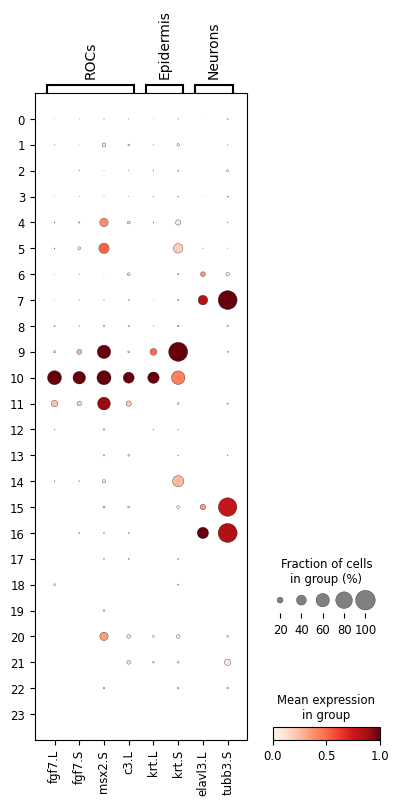

In [50]:
sc.pl.dotplot(hvg_adata, marker_genes, groupby='leiden', standard_scale='var')